# EE675A - Assignment 1: Multi-Armed Bandits

***
## Instructions

- **Release Date**: **23nd Jan 2023**  
- **Deadline**: **5th Feb 2023 11:59PM** 
    > Assignment deadline will not be extended. Make sure you submit well before the deadline <br /> 
    > However, submissions will be open till: **8th Feb 2023 11:59PM** with **-10% penalty** for each late day after deadline

- Kindly name your submission files as `RollNo_Name.ipynb` eg: `18204269_LavishArora.ipynb`. Marks will be deducted for all submissions that do not follow the naming guidelines. <br />
- You are required to work out your answers and submit only the iPython Notebook. The code should be well commented and easy to understand there are marks for this. <br />
- Submissions are to be made through Gradescope only. Submissions made through helloIITK portal or through mail will not be graded.<br />
- Answers to the theory questions should be included in the notebook itself. While using special symbols use the $\LaTeX$ mode <br />
- Make sure your plots are clear and have title, legends and clear lines, etc. <br />
- Plagiarism of any form will not be tolerated. If your solutions are found to match with other students or from other uncited sources, there will be heavy penalties and the incident will be reported to the disciplinary authorities. <br />
- If you have any doubts, feel free to reach out to TAs for help regarding the assignments. <br />

***
## Introduction

This notebook contains questions for Assignment 1 with illustrations adapted from [Alejandro's blog post](https://medium.com/@alejandro.aristizabal24/understanding-reinforcement-learning-hands-on-part-2-multi-armed-bandits-526592072bdc) on Multi-Armed Bandits.

***
## Demo and Preliminaries

We will begin by getting familiar with the basic problem setup before we dig in to the actual assignement problems. Let's start by loading all the required libraries for this notebook. For generating plots you must have `ipympl` installed and `jupyter-matplotlib` extension installed and enabled.

In [1]:
# Import necessary libraries
%matplotlib widget
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import time

## Scenario

The Multi-Armed Bandit describes a situation in which an agent has only one state, and multiple actions to interact with the environment. Each action gives a random reward, centered on an unkown value. Our agent wants to maximize the reward received, which means it wants to find the action that yields a higher reward. Based on this, let's build the scenario.

We're going to implement the multi-armed bandit environment. Also, our implementation will be vectorized for the sake of optimization. This allows us to run multiple agents on multiple environments at the same time. The code below is based on [this implementation](https://github.com/diegoalejogm/openai-k-armed-bandits)

In [2]:
class ArmedBanditsEnv():
    """
    The k-Armed Bandit Environment
    Initialization requires an array of length equals to k, where each item is
    a function which samples from a specified distribution.
    """
    
    def __init__(self, mean, stddev):
        assert len(mean.shape) == 2
        assert len(stddev.shape) == 2
        
        self.num_bandits = mean.shape[1]
        self.num_experiments = mean.shape[0]
        
        self.mean = mean
        self.stddev = stddev
        
    def step(self, action):
        # Sample from the specified bandit using it's reward distribution
        assert (action < self.num_bandits).all()
        
        sampled_means = self.mean[np.arange(self.num_experiments),action]
        sampled_stddevs = self.stddev[np.arange(self.num_experiments),action]
        
        reward = np.random.normal(loc=sampled_means, scale=sampled_stddevs, size=(1,self.num_experiments))
        
        # Return a constant state of 0. Our environment has no terminal state
        observation, done, info = 0, False, dict()
        return observation, reward, done, info

    def SAE_step(self, active, i, s):
        reward = np.array([])
        for j in range(len(active)):
            if active[j] == 1:
                sampled_mean = self.mean[i, j]
                sampled_stddev = self.stddev[i,j]
                reward = np.append(reward,np.random.normal(loc=sampled_mean, scale=sampled_stddev))
                s = s + 1
            else:
                reward = np.append(reward, 0)
                
        return reward, s
    
    def reset(self):
        return 0
        
    def render(self, mode='human', close=False):
        pass
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np.random(seed)
        return [seed]
    
    def close(self):
        pass
    
    
class ArmedBanditsGaussian(ArmedBanditsEnv):
    def __init__(self, num_experiments=1, num_bandits=3):
        self.means = np.random.normal(size=(num_experiments, num_bandits))
        
        ArmedBanditsEnv.__init__(self, self.means, np.ones((num_experiments, num_bandits)))

Here we're creating two classes, `ArmedBanditsEnv` is the main class, while `ArmedBanditsGaussian` is an auxiliary class that allows us to easily create an environment with random mean rewards for each action. Our environment receives numpy arrays for the means and standard deviations for each action. The dimensions of this arrays are described as `num_experiments`x`num_bandits`. Taking a step requires a numpy vector of size `num_experiments`, where each value specifies which action to take for each experiment. The step functions returns, among other information, a vector of reward obtained for each experiment. Let's see this in action:

In [3]:
means = np.array([[5, 1, 0, -10]]) # The mean for a four-armed bandit. Single experiment
stdev = np.array([[1, 0.1, 5, 1]]) # The standard deviation for a four-armed bandit.

env = ArmedBanditsEnv(means, stdev) # Create the environment

for i in range(4):
    action = np.array([[i]])
    _, reward, _, _ = env.step(action)
    print("Bandit:", i, " gave a reward of:", reward[0])

Bandit: 0  gave a reward of: [5.98537655]
Bandit: 1  gave a reward of: [0.9542984]
Bandit: 2  gave a reward of: [-0.64310121]
Bandit: 3  gave a reward of: [-8.57685704]


## Evaluating our actions

In order to learn something from our interaction with the environment, we need to know how exactly we determine the value of our actions, as well as how to keep that value up to date. A simple strategy our agents can take is to calculate the expected return for each action. This can be done through experience by taking the average of previous rewards given by a determined action.

For example, we can use the next list of rewards to calculate the expected return of the chosen action:

$\bar{\mu}_t = \dfrac{R_1+R_2+\dots+R_t}{t}$

Having to store all the previously seen rewards to calculate the value of an action is cumbersome, inefficient and unnecessary. We can derive another form of average, called *Incremental average update rule*, which only requires us to know the previous average $\bar{\mu}_{t-1}$ and the number $t$:

$\bar{\mu}_t = \bar{\mu}_{t-1} + \dfrac{1}{t}(R_t - \bar{\mu}_{t-1})$

Here's a small demonstration of this function at work

In [4]:
def inc_avg(prev_avg, new_val, n):
    return prev_avg + 1/n*(new_val - prev_avg)

# Obtain the previous average
vals = np.array([4.5, 5.04, 5.32, 4.8, 5.11])
prev_avg = vals.mean()

# Calculate a new average using the incremental average update function
new_val = 5.18
new_avg = inc_avg(prev_avg, new_val, 6)

# Calculate the same average using all previous values for comparison
avg = np.append(vals, new_val).mean()

print("Average obtained from incremental update rule: ", new_avg)
print("Average obtained from basic average function:  ", avg)

Average obtained from incremental update rule:  4.991666666666666
Average obtained from basic average function:   4.991666666666666


This method will be used on the next strategies

## The Greedy Agent

This strategy is focused on always choosing the best known action at the time. Every time the agent takes an action, it looks at the estimated values for each action, and chooses the one that has a greater score. If more than two values look best, then the agent selects arbitrarily among those best-valued actions. This is called breaking ties arbitrarily

Taking the action with the greatest value is equivalent to using the **argmax** function. Although, we need to implement some changes so that the funciton breaks the ties the way we intend it to do:

In [5]:
def argmax(q_values):
    """
    Takes in a matrix of n*k q_values and returns the index
    of the item with the highest value for each row. 
    Breaks ties randomly.
    returns: vector of size n, where each item is the index of
    the highest value in q_values for each row.
    """
    # Generate a mask of the max values for each row
    mask = q_values == q_values.max(axis=1)[:, None]
    # Generate noise to be added to the ties
    r_noise = 1e-6*np.random.random(q_values.shape)
    # Get the argmax of the noisy masked values
    return np.argmax(r_noise*mask,axis=1)

Here we're generating a mask of all the values in the input that are equal to the maximum value. Then ,we generate some noise and multiply it with the mask. Taking the argmax of this new list will be equivalent to the desired argmax with ties broken arbitrarily. 

Now that we have specified the argmax function, we can declare our class for the Greedy Agent, which is capable of acting upon the environment, and updating its estimates after receiving a reward.

In [6]:
class GreedyAgent:
    def __init__(self, reward_estimates):
        """
        Our agent takes as input the initial reward estimates.
        This estimates will be updated incrementally after each 
        interaction with the environment.
        """
        assert len(reward_estimates.shape) == 2
        
        self.num_bandits = reward_estimates.shape[1]
        self.num_experiments = reward_estimates.shape[0]
        self.reward_estimates = reward_estimates.astype(np.float64)
        self.action_count = np.zeros(reward_estimates.shape)
        
    def get_action(self):
        # Our agent is greedy, so there's no need for exploration.
        # Our argmax will do just fine for this situation
        action = argmax(self.reward_estimates)
        
        # Add a 1 to each action selected in the action count
        self.action_count[np.arange(self.num_experiments), action] += 1
        
        return action
    
    def update_estimates(self, reward, action):
        # rew is a matrix with the obtained rewards from our previuos
        # action. Use this to update our estimates incrementally
        n = self.action_count[np.arange(self.num_experiments), action]
        prev_reward_estimates = self.reward_estimates[np.arange(self.num_experiments), action]
        
        # Update the reward estimates incementally
        self.reward_estimates[np.arange(self.num_experiments), action] = inc_avg(prev_reward_estimates,reward,n)

The greedy agent contains a matrix for the estimates, as well as for the number of times each action has been taken. This is necessary for using the incremental average update rule, used inside the `update_estimates` function.

### Testing the agent

Let's see how the Greedy Agent behaves on the environment. For this, we're going to generate some animations where we're able to see how the agent estimates the values for each action, as well as the real values provided by the environment. Remember that the agent doesn't have access to that information.

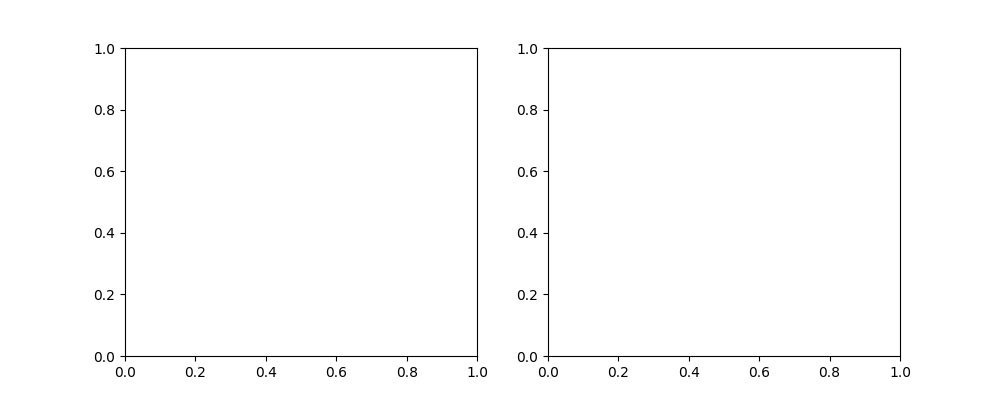

In [7]:
# Initialize the environment of our multi-armed bandit problem
num_experiments = 2
num_bandits = 8
num_steps = 100
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBanditsEnv(means, stdev)

# Initialize the agent
agent = GreedyAgent(np.zeros((num_experiments,num_bandits)))

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    for i in range(num_experiments):
        init_ax(i)
        
def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)

# Implement a step, which involves the agent acting upon the
# environment and learning from the received reward.
def step(g):
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        estimates = agent.reward_estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()
    
anim = FuncAnimation(fig, func=step, frames=num_steps, init_func=init, interval=10, repeat=True, blit=True)
plt.show()

# Uncomment the next line if you wish to store the animations as a gif
# anim.save('./greedy-agent.gif', writer='imagemagick', fps=60)


you may try the previous block of code multiple times to see multiple animations. In general, you may realize that most of the actions are not explored by the agent, and that it will mostly stick to the one action that gave it some positive reward. The agent is good at evading negative values, but it will only land on the optimal action by pure chance.

We can plot the average behavior by doing more experiments. The next plot displays the percentage of times the agent chose the optimal action over an average of 10000 experiments.

100%|██████████| 1000/1000 [00:03<00:00, 264.14it/s]


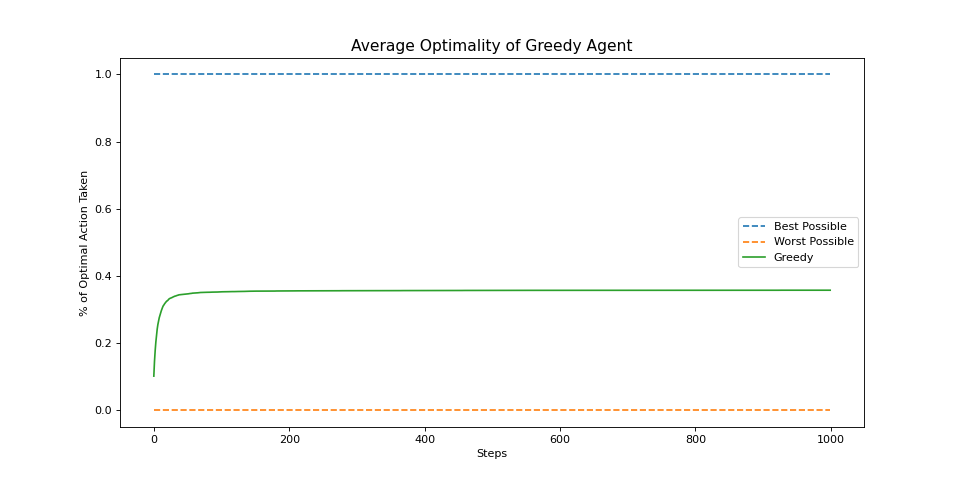

In [8]:
num_experiments = 10000
num_steps = 1000
num_actions = 10

# Initialize the environment
env = ArmedBanditsGaussian(num_experiments, num_actions)
# Initialize the agent
agent = GreedyAgent(np.zeros((num_experiments, num_actions)))

# Store the scores and averages for later plotting
averages = np.zeros((num_steps))
optimality = np.zeros((num_steps))
scores = np.zeros((num_experiments, num_steps+1))

#Store the optimal actions for later use
optimal = np.argmax(env.mean, axis=1)

for i in tqdm(range(num_steps)):
    # Select an action to execute on the environment
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    
    # Update the agent estimates with the previously observed rewards
    agent.update_estimates(reward, action)
    
    # Store the average cumulative score and optimality of the current step
    scores[:,i+1] = scores[:,i] + reward
    avg_score = np.mean(scores[:,i+1]/(i+1))
    averages[i] = avg_score
    
    # Get optimal actions from the environment
    current_optimality = np.mean(action == optimal)
    optimality[i] = current_optimality
    
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(optimality)
plt.legend(["Best Possible", "Worst Possible", "Greedy"])
plt.title("Average Optimality of Greedy Agent", fontsize=14)
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()
greedy_scores = averages
greedy_optimality = optimality

The Greedy Agent chooses the best action on average ~40% of the times. Additionally, extra experience won't improve it's score, as it usually lands on a sub-optimal action on the first steps, and stays there for ever. The Greedy Agent is not a good strategy for finding the optimal action on this scenario.

## The Epsilon-Greedy Agent

Another strategy is the Epsilon Greedy Agent, which adds to the previous strategy. An Epsilon-Greedy Agent allows for some exploratory actions, by every once in a while choosing any action randomly, instead of always acting greedily. The probability of taking an exploratory action is defined by the parameter `epsilon`. An epsilon of `0` is a Greedy Agent. An epsilon of `0.2` means our agent takes a random action 20% of the time. An epsilon of `1` is an agent that behaves randomly. Let's build this new agent

In [9]:
class EpsilonGreedyAgent(GreedyAgent):
    def __init__(self, reward_estimates, epsilon):
        GreedyAgent.__init__(self, reward_estimates)
        # Store the epsilon value
        assert epsilon >= 0 and epsilon <= 1
        self.epsilon = epsilon
    
    def get_action(self):
        # We need to redefine this function so that it takes an exploratory action with epsilon probability
        
        # One hot encoding: 0 if exploratory, 1 otherwise
        action_type = (np.random.random_sample(self.num_experiments) > self.epsilon).astype(int)
        # Generate both types of actions for every experiment
        exploratory_action = np.random.randint(self.num_bandits, size=self.num_experiments)
        greedy_action = argmax(self.reward_estimates)
        # Use the one hot encoding to mask the actions for each experiment
        action = greedy_action * action_type + exploratory_action * (1 - action_type)
        
        self.action_count[np.arange(self.num_experiments), action] += 1
        
        return action

As may be seen, we're inheriting the `GreedyAgent` implementation, and only changing the `get_action` function. For taking an action, we're using a masking that defines which experiments will choose an action randomly and which will act greedily. Then, we apply that masking between random and greedy actions to obtain the action vector for all of our experiments.

### Testing the Agent

Here, we're going to use the same animation as before to observe how this new strategy behaves. Our agents will have a value of epsilon of `0.1`

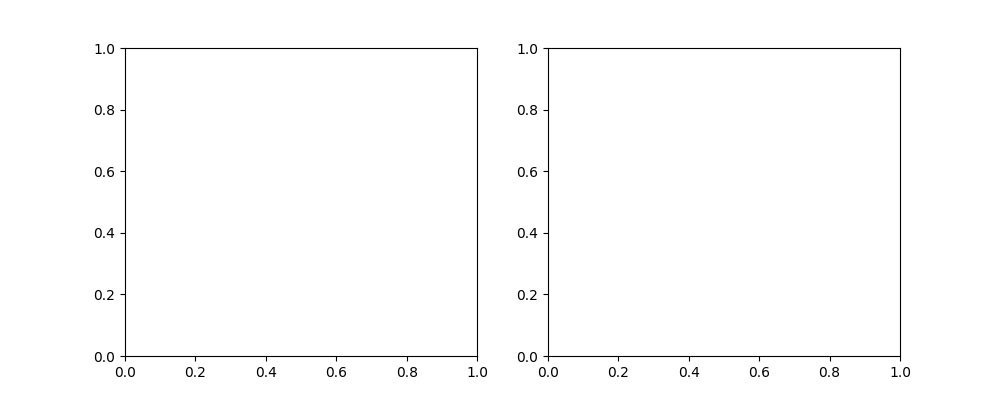

In [10]:
# Initialize the environment of our multi-armed bandit problem
num_experiments = 2
num_bandits = 8
num_steps = 200
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBanditsEnv(means, stdev)

# Initialize the agent
agent = EpsilonGreedyAgent(np.zeros((num_experiments,num_bandits)), 0.1)

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    for i in range(num_experiments):
        init_ax(i)
        
    
def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)
    
# Implement a step, which involves the agent acting upon the
# environment and learning from the received reward.
def step(g):
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        estimates = agent.reward_estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()
    
anim = FuncAnimation(fig, func=step, frames=np.arange(num_steps), init_func=init, interval=10, repeat=True, blit=True)
plt.show()

# Uncomment the next line if you wish to store the animations as a gif
# anim.save('./epsilon-greedy-agent.gif', writer='imagemagick', fps=60)

Again, you may run the previous block multiple times to see different runs. As can be observed, the epsilon-greedy agent not only finds the optimal solution most of the times, but it is also capable of finding close estimated values for all the actions! Observe how the new strategy compares to the greedy agent on average.

In [11]:
def run_experiment(num_experiments=1000, num_steps=1000, num_actions=10,epsilon=0.1):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    # Initialize the agent
    agent = EpsilonGreedyAgent(np.zeros((num_experiments, num_actions)), epsilon)
    
    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))
    
    #Store the optimal actions for later use
    optimal = np.argmax(env.mean, axis=1)
    
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        _, reward, _, _ = env.step(action)
        
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)
        
        # Store the average cumulative score and optimality of the current step
        scores[:,i+1] = scores[:,i] + reward
        avg_score = np.mean(scores[:,i+1]/(i+1))
        averages[i] = avg_score
        
        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[i] = current_optimality
    return optimality, averages

100%|██████████| 1000/1000 [00:03<00:00, 253.73it/s]


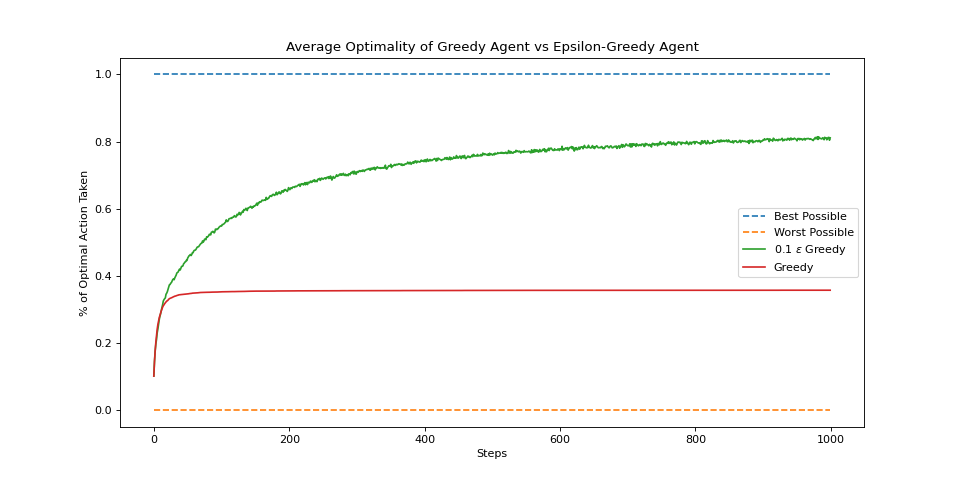

In [12]:
num_experiments = 10000
num_steps = 1000
num_actions = 10
epsilon = 0.1

balanced_eps_optimality, balanced_eps_scores = run_experiment(num_experiments, num_steps, num_actions, epsilon)

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.0 for _ in range(num_steps)], linestyle='--')
plt.plot([0.0 for _ in range(num_steps)], linestyle='--')
plt.plot(balanced_eps_optimality)
plt.plot(greedy_optimality)
plt.legend(["Best Possible", "Worst Possible", "0.1 $\epsilon$ Greedy", "Greedy"])
plt.title("Average Optimality of Greedy Agent vs Epsilon-Greedy Agent")
plt.ylabel("% of Optimal Action Taken")
plt.xlabel("Steps")
plt.show()

After 1000 steps, the Epsilon-Greedy Agent is capable of reaching an 80% average optimality. This means that on average, they choose the best possible action 80% of the times after that amount of iterations. We can also see how our agent is capable of improving from experience, contrary to the Greedy Agent.

## Values for epsilon

On the previous example, we used a value for `epsilon` of `0.1`. This means that the agent chose an exploratory action 10% of the times. Like with almost all hyper-parameters in Machine Learning, there's a range of values which behave better than others. Let's make an actual experiment using different values for `epsilon`

100%|██████████| 1000/1000 [00:00<00:00, 2063.84it/s]


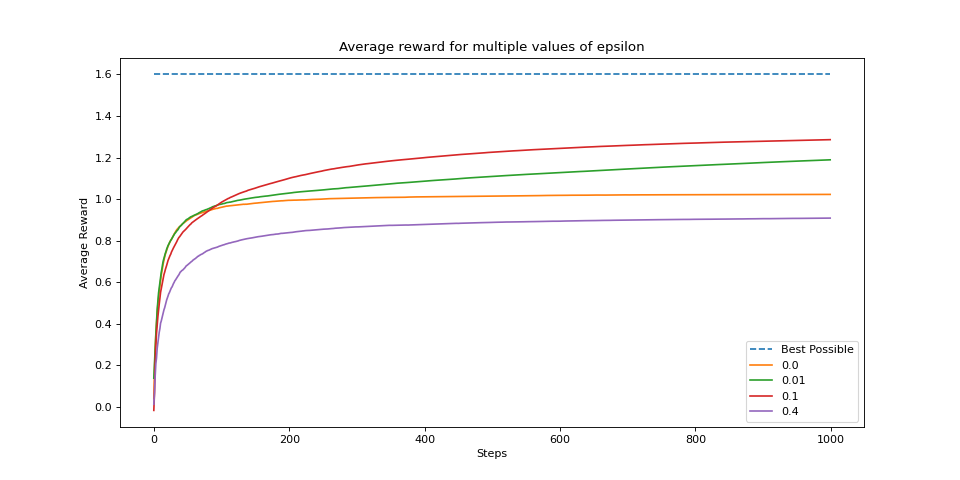

In [13]:
num_experiments = 1000
num_steps = 1000
num_actions = 10
epsilons = np.array([0.0, 0.01, 0.1, 0.4])

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.6 for _ in range(num_steps)], linestyle='--') # why 1.6?


for epsilon in epsilons:
    _, reward = run_experiment(num_experiments, num_steps, num_actions, epsilon)
    
    plt.plot(reward)
    
plt.legend(["Best Possible"] + epsilons.tolist())
plt.title("Average reward for multiple values of epsilon")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

Here, we're plotting the average amount of reward received by the agent. This is because plotting the optimality on this many tests gets too crowded and noisy. As can be seen, the agent with an epsilon of `0.1` was the one that received the most amount of reward. Values of epsilon that are too small take very few exploratory actions, and therefore take a long time to explore and find the most optimal value. On the other hand, values of `epsilon` too high will obstruct the capacity of the agent of acting optimally. Too much exploration gets in the way of exploitation.

***
# Assignment questions

Now that we have familiarized ourselves with the basic setup let us test a few more stratergies and see how they compare to the greedy and the epsilon greedy agent stratergies. 

## Part 1: Time Varying $\epsilon$-Greedy Algorithm

Create an agent that implements the Time Verying $\epsilon$-Greedy strategy. Implement using two parameters, one for the starting value of $\epsilon=\epsilon_0$ and other for the decay rate linear/exponential. Starting with the value of $\epsilon_0=1$ for epsilon and decay it linearly/exponentially to a very small value. The type of decay and the starting value of epsilon are input parameters to the function, include these in the function definition.

linear rate $\epsilon = \epsilon_0(1-t/T)$ <br />
exponential rate $\epsilon = \epsilon_0t^{-1/3}$

### 1.1 Time Varying $\epsilon$-Greedy Agent 

For this part realize an agent class that executes the Time Varying $\epsilon$-Greedy Algorithm. `[5 Marks]`

In [14]:
# Desired Agent class implementation

class TimeVaryingEpsilonGreedyAgent(GreedyAgent):
    def __init__(self, reward_estimates, epsilon_0, decay, num_steps):
        GreedyAgent.__init__(self, reward_estimates)
        self.epsilon_0 = epsilon_0
        self.decay = decay
        self.current = 0 # For keeping the track of current step
        self.numsteps = num_steps
    
    def get_action(self):
        # Updating the epsilon according to linear or exponential decay
        if self.decay == 0:
            epsilon = self.epsilon_0*(1-(self.current/self.numsteps))
        if self.decay == 1:
            epsilon = self.epsilon_0*pow(self.current+1,-(1/3))

        # One hot encoding: 0 if exploratory, 1 otherwise
        action_type = (np.random.random_sample(self.num_experiments) > epsilon).astype(int)

        exploratory_action = np.random.randint(self.num_bandits, size=self.num_experiments)
        greedy_action = argmax(self.reward_estimates)
        
        # Use the one hot encoding to mask the actions for each experiment
        action = greedy_action * action_type + exploratory_action * (1 - action_type)

        self.current = self.current + 1 # Updating the current step
        
        self.action_count[np.arange(self.num_experiments), action] += 1
        
        return action



### 1.2 Testing the agent

Observe how this Time varying $\epsilon$-greedy Agent behaves on the environment for linear decay case with $\epsilon_0 = 1$. For this, try to generate some animations as before to see how the agent estimates the values for each action, as well as the real values provided by the environment. Remember that the agent doesn't have access to that information. Write your code below `[2 Marks]`

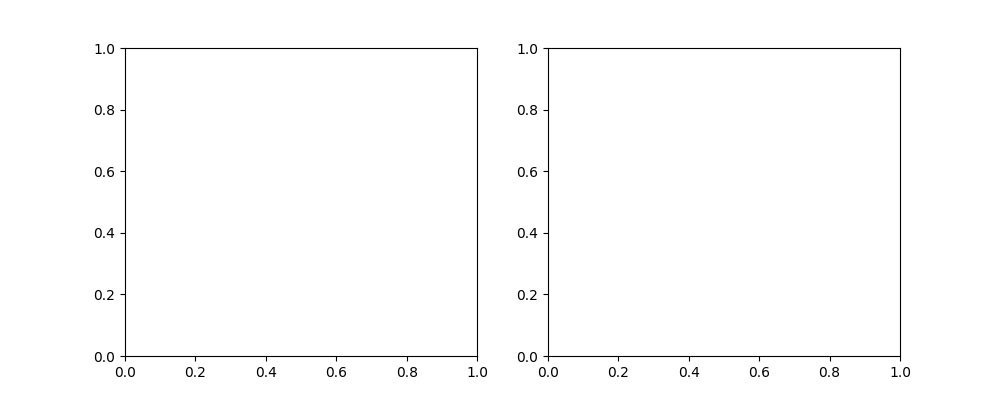

In [15]:
# Write your code for testing the Time varying epsilon greedy agent

num_experiments = 2
num_bandits = 8
num_steps = 2000
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBanditsEnv(means, stdev)


agent = TimeVaryingEpsilonGreedyAgent(np.zeros((num_experiments,num_bandits)), 1, 0, num_steps)

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    for i in range(num_experiments):
        init_ax(i)
        
    
def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated vs. Real values', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)
    
def step(g):
    action = agent.get_action()
    _, reward, _, _ = env.step(action)
    agent.update_estimates(reward, action)
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        estimates = agent.reward_estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()
    
anim = FuncAnimation(fig, func=step, frames=np.arange(num_steps), init_func=init, interval=10, repeat=True, blit=True)
plt.show()



### 1.3 Experimenting with parameters

Design and test using an experiment using different values for $\epsilon_0 \in$ `{0 0.01 0.1 0.5 1}` along with linear and exponential decay scheme similar to what we earlier did. Write your code below for the experiment and plot the average reward and the average optimality ratio for various values of $\epsilon$ and decay scheme. What combination of $\epsilon$ and decay scheme generates the maximum average reward over 1000 steps? What value of $\epsilon_0$ and decay scheme leads to highest average optimality? Is your answer to the above two parts same? `[3 Marks]`

In [16]:
# Write your code for the experiment to test different values of parameters for Time varying epsilon-greedy agent

def tveg_experiment(num_experiments=1000, num_steps=1000, num_actions=10, epsilon_0 = 1, decay = 0):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    # Initialize the agent
    agent = TimeVaryingEpsilonGreedyAgent(np.zeros((num_experiments, num_actions)), epsilon_0, decay, num_steps)
    
    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))
    
    #Store the optimal actions for later use
    optimal = np.argmax(env.mean, axis=1)
    
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        _, reward, _, _ = env.step(action)
        
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)
        
        # Store the average cumulative score and optimality of the current step
        scores[:,i+1] = scores[:,i] + reward
        avg_score = np.mean(scores[:,i+1]/(i+1))
        averages[i] = avg_score
        
        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[i] = current_optimality
    return optimality, averages


100%|██████████| 1000/1000 [00:00<00:00, 1963.67it/s]


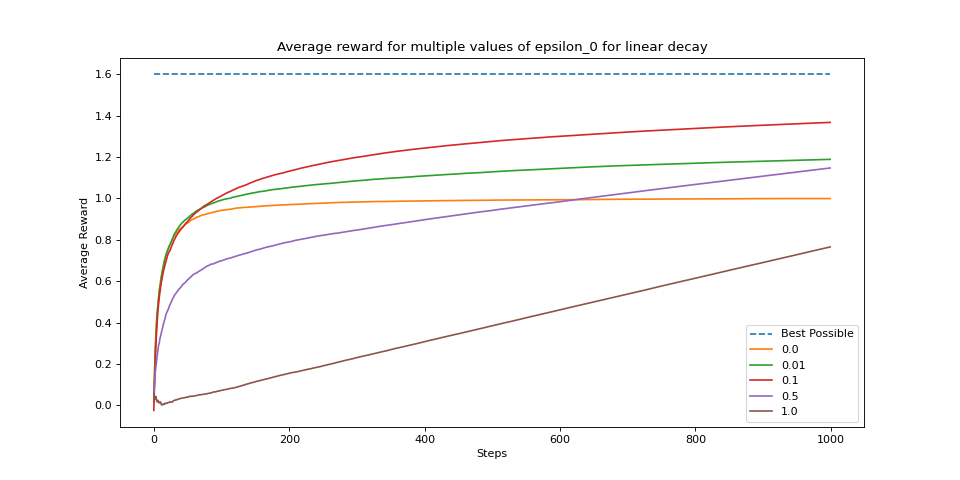

In [17]:
num_experiments = 1000
num_steps = 1000
num_actions = 10
epsilons = np.array([0.0, 0.01, 0.1, 0.5, 1])

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.6 for _ in range(num_steps)], linestyle='--')

for epsilon in epsilons:
    optimality, reward = tveg_experiment(num_experiments, num_steps, num_actions, epsilon, 0)
    plt.plot(reward)
    
plt.legend(["Best Possible"] + epsilons.tolist())
plt.title("Average reward for multiple values of epsilon_0 for linear decay")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 1818.64it/s]


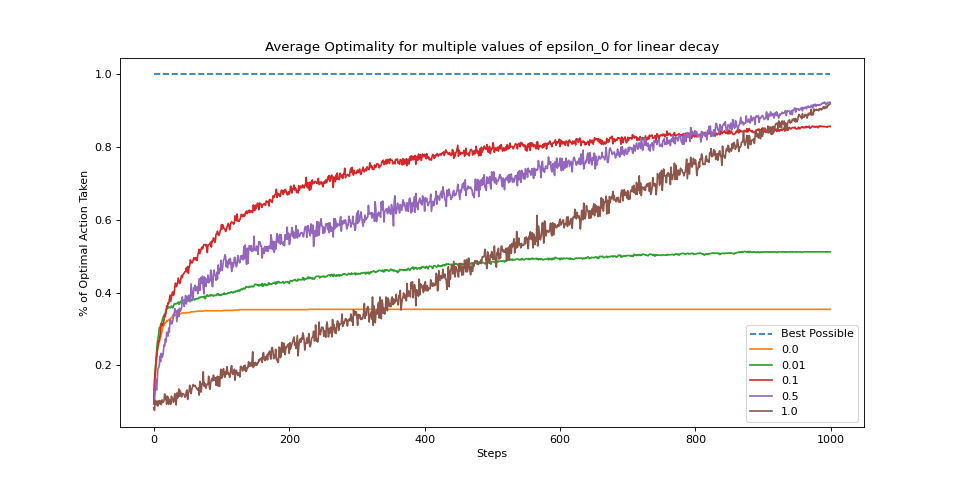

In [18]:
num_experiments = 1000
num_steps = 1000
num_actions = 10
epsilons = np.array([0.0, 0.01, 0.1, 0.5, 1])

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1 for _ in range(num_steps)], linestyle='--') 

for epsilon in epsilons:
    optimality, _ = tveg_experiment(num_experiments, num_steps, num_actions, epsilon, 0)
    plt.plot(optimality)
    
    
plt.legend(["Best Possible"] + epsilons.tolist())
plt.title("Average Optimality for multiple values of epsilon_0 for linear decay")
plt.xlabel("Steps")
plt.ylabel("% of Optimal Action Taken")
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 1826.25it/s]


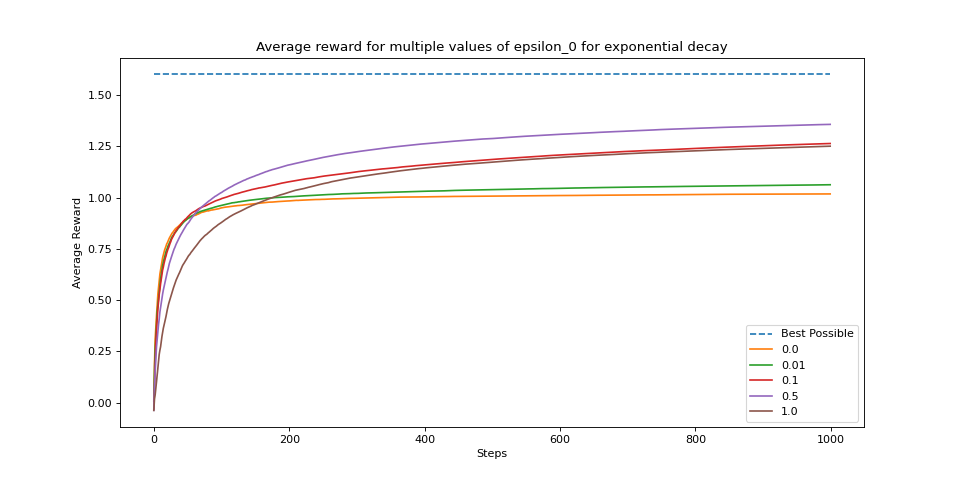

In [19]:
num_experiments = 1000
num_steps = 1000
num_actions = 10
epsilons = np.array([0.0, 0.01, 0.1, 0.5, 1])

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.6 for _ in range(num_steps)], linestyle='--') 

for epsilon in epsilons:
    _, reward = tveg_experiment(num_experiments, num_steps, num_actions, epsilon, 1)
    plt.plot(reward)
    
    
plt.legend(["Best Possible"] + epsilons.tolist())
plt.title("Average reward for multiple values of epsilon_0 for exponential decay")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 1736.74it/s]


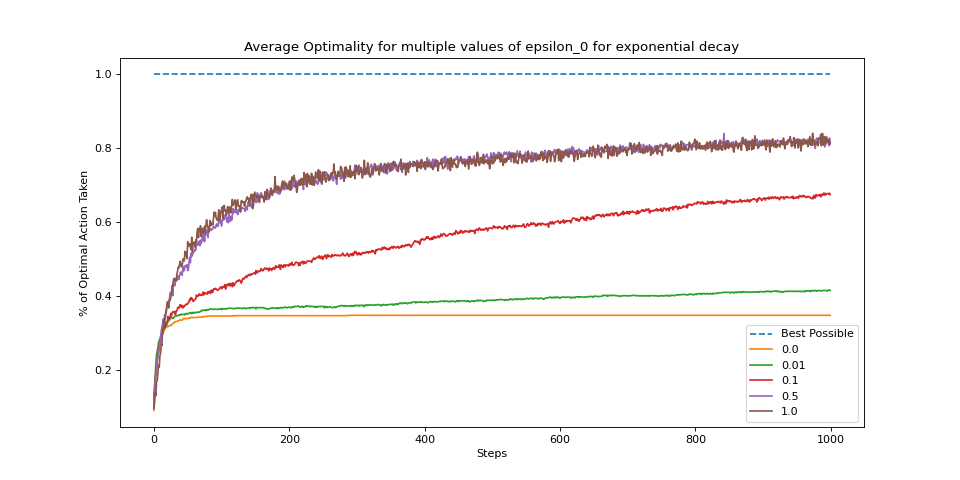

In [20]:
num_experiments = 1000
num_steps = 1000
num_actions = 10
epsilons = np.array([0.0, 0.01, 0.1, 0.5, 1])

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1 for _ in range(num_steps)], linestyle='--')

for epsilon in epsilons:
    optimality, _ = tveg_experiment(num_experiments, num_steps, num_actions, epsilon, 1)
    plt.plot(optimality)
    
    
plt.legend(["Best Possible"] + epsilons.tolist())
plt.title("Average Optimality for multiple values of epsilon_0 for exponential decay")
plt.xlabel("Steps")
plt.ylabel("% of Optimal Action Taken")
plt.show()

* The combination of **exponential** decay with **$\epsilon_0$ = 0.5** gives the best reward.

* The combination of **linear** decay with **$\epsilon_0$ = 0.5** gives best results on optimality.  

* The best optimality and best reward combination is not the same. But the $\epsilon_0$ remains the same.


## Part 2: Successive Elimination Algorithm (SEA)

Create an agent that solves the given MAB problem using the successive elimination algorithm. The algorithm adaptively eliminates arms that are detected to be worse that other arms with high probability using the deactivation rule. Realize your agent using the weight parameter `c` for the uncertainity term.

### 2.1 SEA Agent

For this part realize an agent class that executes the Successive Elimination Algorithm as discussed in the class. For this part you may need to use the weight parameter `c` for the uncertainity term.In the class we have used $c = \sqrt{2}$, here we experiment with other values of parameter $c$  

$LCB_t(a) = \mu_t - c \cdot \sqrt{\frac{\log T}{n_t(a)}}$, $UCB_t(a) = \mu_t + c \cdot \sqrt{\frac{\log T}{n_t(a)}}$

`[5 Marks]`

In [21]:
# SEA Agent implementation

class SEA:
    def __init__(self, reward_estimates, total_steps, c):
        self.reward_estimates = reward_estimates
        self.num_bandits = reward_estimates.shape[1]
        self.num_experiments = reward_estimates.shape[0]
        self.c = c

        self.action_count = np.zeros(self.num_bandits)
        self.active = np.ones(self.num_bandits)
        self.total_steps = total_steps


    def radius(self):
        return self.c * np.sqrt(np.log(self.total_steps)/self.action_count)

    def lcb(self, i):
        return self.reward_estimates[i] - self.radius()
    
    def ucb(self, i):
        return self.reward_estimates[i] + self.radius()

    def eliminate_bandit(self, i):
        lcb = self.lcb(i)
        ucb = self.ucb(i)

        max_lcb = lcb[self.active.astype(bool)].max()
        mask = ucb >= max_lcb
        
        self.active = self.active * mask
    
    def update_estimates(self, reward, i):
        self.action_count = self.action_count + self.active
        self.reward_estimates[i] = inc_avg(self.reward_estimates[i],reward,self.action_count)
 

### 2.2 Testing the Agent

Observe how this SEA Agent behaves on the environment for a fixed value of parameter `c = 1`. For this, try to generate some animations as before to see how the agent estimates the values for each action, as well as the real values provided by the environment. For this part try and plot the confidence interval for the reward estimate of each arm rather than just the point estimates. Write your code below `[2 Marks]`

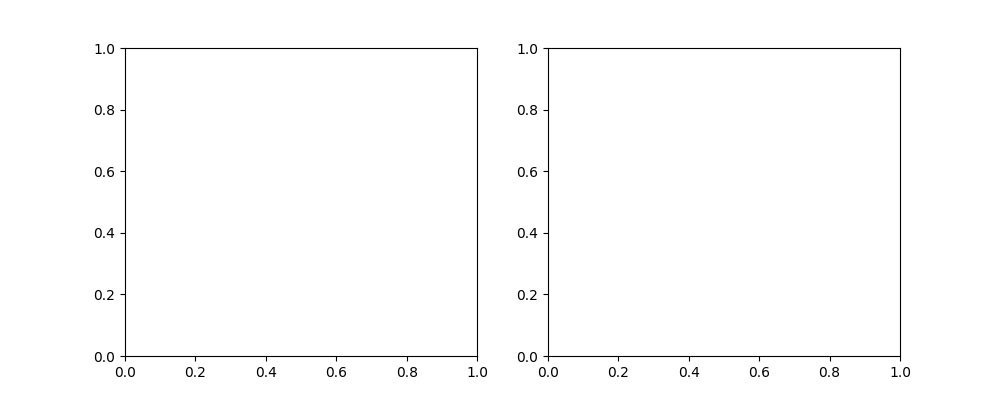

In [22]:
# Write your code for testing the SEA agent

num_experiments = 2
num_bandits = 8
num_steps = 2000
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBanditsEnv(means, stdev)

# Initialize the agent
agent = SEA(np.zeros((num_experiments,num_bandits)), num_steps, 1)

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    for i in range(num_experiments):
        init_ax(i)
        
    
def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated Values vs. Real values', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)

arr1 = []
# Implementing a step, which involves the agent acting upon the
# environment and learning from the received reward.
def sae_step(g):
    for i in range(num_experiments):
        s = 0
        agent.reward_estimates = np.zeros((num_experiments,num_bandits))
        agent.active = np.ones(agent.num_bandits)
        agent.action_count = np.zeros(agent.num_bandits)


        while (s < num_steps):
            reward, step = env.SAE_step(agent.active, i, s) 
            # New SEA_step function defined for SEA Agent in environment class
            s  = step + s
            arr1.append(s)
            agent.update_estimates(reward, i)
            agent.eliminate_bandit(i)

        ax = axs[i]
        estimates = agent.reward_estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()


anim = FuncAnimation(fig, func=sae_step, frames=np.arange(num_steps), init_func=init, interval=10, repeat=True, blit=True)
plt.show()


### 2.3 Values for weight parameter `c`

Design and test using an experiment using different values for `c` in `{0 1 2 3 4}` similar to what we earlier did. Write your code below for the experiment and plot the average reward and the average optimality ratio for various values of `c`. What value of `c` generates the maximum average reward over 1000 steps? What value of `c` leads to highest average optimality? Is your answer to the above two parts same? `[3 Marks]`

In [23]:
# Write your code for the experiment to test different values of weight parameters

def sea_experiment(num_experiments=1000, num_steps=1000, num_actions=10, c = np.sqrt(2)):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    # Initialize the agent
    agent = SEA(np.zeros((num_experiments,num_bandits)), num_steps, c)

    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))
    
    #Store the optimal actions for later use
    optimal = np.argmax(env.mean, axis=1)

    ac = [] # for storing all the actions that we take in an experiment

    for k in range(num_experiments):
        ac.append([])

    def s_step(num_steps):
        for i in tqdm(range(num_experiments)):
            s = 0
            agent.reward_estimates = np.zeros((num_experiments,num_bandits))
            agent.active = np.ones(agent.num_bandits)
            agent.action_count = np.zeros(agent.num_bandits)
            r = 0 

            while (s < num_steps):
                reward, step = env.SAE_step(agent.active, i, 0)
                agent.update_estimates(reward, i)
                agent.eliminate_bandit(i)
                
                for j in range(len(reward)):
                    if(s + j <= num_steps and reward[j]!=0):
                        r = reward[j] + r
                        scores[i, s + j] = r

                    if(reward[j]!=0):
                        ac[i].append(j) 
                        
                s = step + s

    s_step(num_steps)

    for i in range(num_steps):
        avg_score = np.mean(scores[:,i+1]/(i+1))
        averages[i] = avg_score

    ac1 = []

    for i in range(len(ac)):
        ac1.append(ac[i][:num_steps])

    op = np.zeros((num_experiments, num_steps)) # For storing optimality in each experiment 

    ac1 = np.array(ac1)

    for i in range(num_experiments):
        for j in range(num_steps):
            op[i, j] = (np.count_nonzero(ac1[i, :j] == optimal[i]))/(j+1)

    optimality = np.mean(op, axis=0)

    return optimality, averages


100%|██████████| 1000/1000 [00:11<00:00, 87.81it/s]


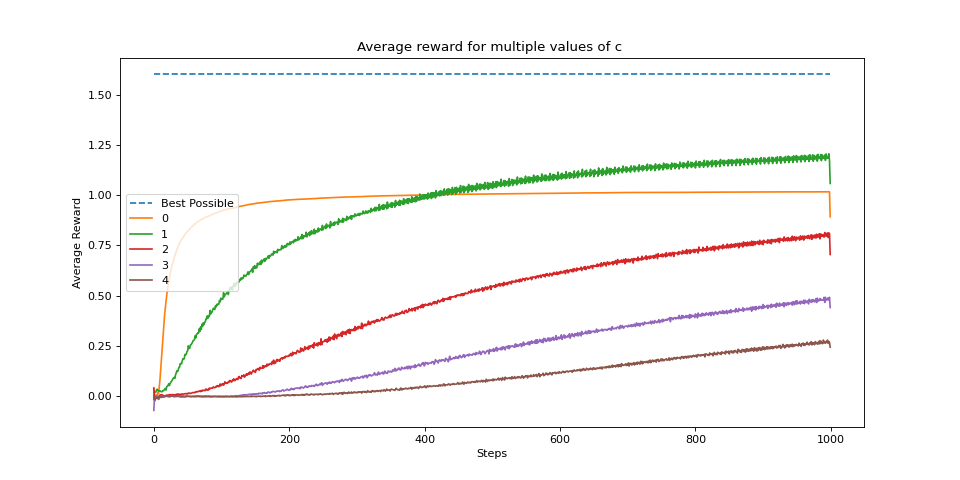

In [24]:
num_experiments = 1000
num_steps = 1000
num_actions = 10
cs = np.array([0, 1, 2, 3, 4])

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.6 for _ in range(num_steps)], linestyle='--') 

for c in cs:
    optimality, reward = sea_experiment(num_experiments, num_steps, num_actions, c)
    plt.plot(reward)
    
plt.legend(["Best Possible"] + cs.tolist())
plt.title("Average reward for multiple values of c ")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

100%|██████████| 1000/1000 [00:11<00:00, 89.12it/s]


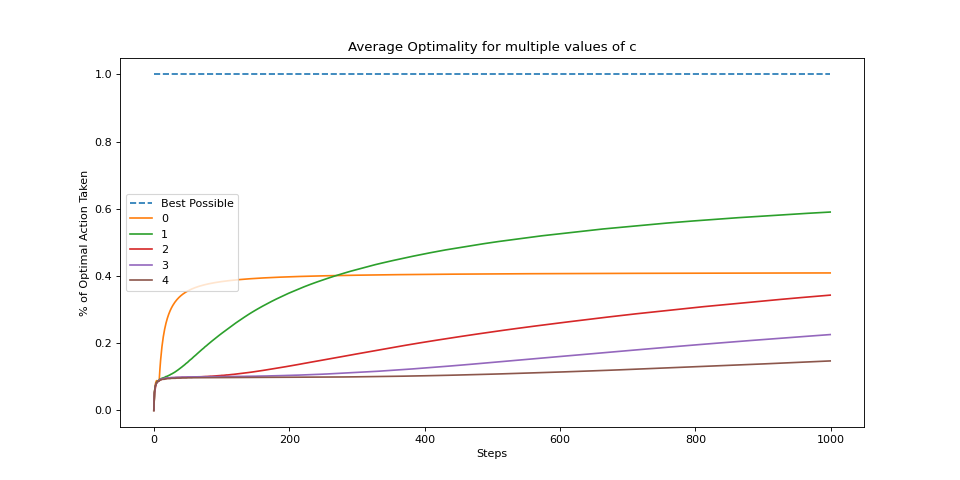

In [25]:
num_experiments = 1000
num_steps = 1000
num_actions = 10
cs = np.array([0, 1, 2, 3, 4])

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1 for _ in range(num_steps)], linestyle='--')

for c in cs:
    optimality, reward = sea_experiment(num_experiments, num_steps, num_actions, c)
    plt.plot(optimality)
    
plt.legend(["Best Possible"] + cs.tolist())
plt.title("Average Optimality for multiple values of c")
plt.xlabel("Steps")
plt.ylabel("% of Optimal Action Taken")
plt.show()

* For SEA algorithm, at **c = 1**, we observe the best reward and optimality.

## Part 3: The Upper-Confidence-Bound (UCB) Algorithm

The greedy actions are those that look best at present, but some of the other actions may actually be better. epsilon-greedy action selection forces the non-greedy actions to be tried, but indiscriminately, with no preference for those that are nearly greedy or particularly uncertain. It would be better to select among the non-greedy actions according to their potential for actually being optimal, taking into account both how close their estimates are to being maximal and the uncertainties in those estimates. 

### 3.1 UCB Agent

For this part realize an agent class that executes the UCB Algorithm as discussed in the class. For this part you may need to use the weight parameter $c$ for the uncertainity term. In the class we have used $c = \sqrt{2}$, here we experiment with other values of parameter $c$  

$UCB_t = \mu_t + c \cdot \sqrt{\frac{\log T}{n_t(a)}}$

`[5 Marks]`

In [26]:
# UCB Agent implementation

class UCBAgent:
    def __init__(self, reward_estimates, c, num_steps):
        self.num_bandits = reward_estimates.shape[1]
        self.num_experiments = reward_estimates.shape[0]
        self.total_steps = num_steps
        self.c = c
        self.action_count = np.ones(reward_estimates.shape)
        self.reward_estimates = reward_estimates
        self.r = np.ones(reward_estimates.shape)

    def radius(self):
        self.r = np.sqrt(self.c * np.log(self.total_steps)/self.action_count)
        return np.sqrt(self.c * np.log(self.total_steps)/self.action_count)

    def ucb(self):
        return self.reward_estimates + self.radius()
    
    def get_action(self, step_i):
        # Sampling all actions initially
        if(step_i<self.num_bandits):
            action =  np.full((self.num_experiments), step_i)
        # Sampling the best UCB action
        else:
            action =  argmax(self.ucb())
        
        self.action_count[np.arange(self.num_experiments), action] += 1
        return action

    def update_estimates(self, reward, action):
        
        n = self.action_count[np.arange(self.num_experiments), action]
        prev_reward_estimates = self.reward_estimates[np.arange(self.num_experiments), action]
        
        # Update the reward estimates incementally
        self.reward_estimates[np.arange(self.num_experiments), action] = inc_avg(prev_reward_estimates,reward,n)


### 3.2 Testing the agent

Observe how this UCB Agent behaves on the environment for a fixed value of parameter `c = 1`. For this, try to generate some animations as before to see how the agent estimates the values for each action, as well as the real values provided by the environment. Remember that the agent doesn't have access to that information. For this part try and plot the confidence interval for the reward estimate of each arm rather than just the point estimates. Write your code below `[2 Marks]`

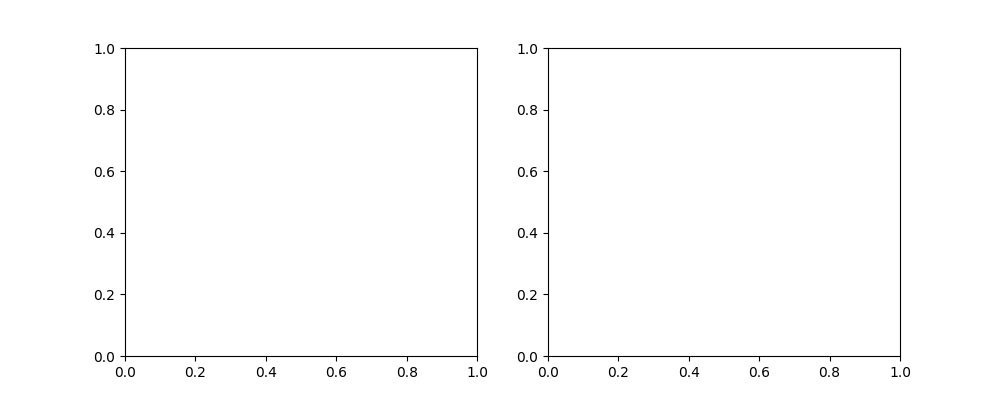

In [27]:
# Write your code for testing the UCB agent

num_experiments = 2
num_bandits = 8
num_steps = 10000
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBanditsEnv(means, stdev)

agen = UCBAgent(np.zeros((num_experiments,num_bandits)), 1, num_steps)

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    for i in range(num_experiments):
        init_ax(i)
        
    
def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated vs. Real values', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)
    
def step(g):
    action = agen.get_action(g)
    _, reward, _, _ = env.step(action)
    agen.update_estimates(reward, action)
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        estimates = agen.reward_estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()
    
anim = FuncAnimation(fig, func=step, frames=np.arange(num_steps), init_func=init, interval=10, repeat=True, blit=True)
plt.show()

In [28]:
# Uncomment to install scipy
# !pip install scipy

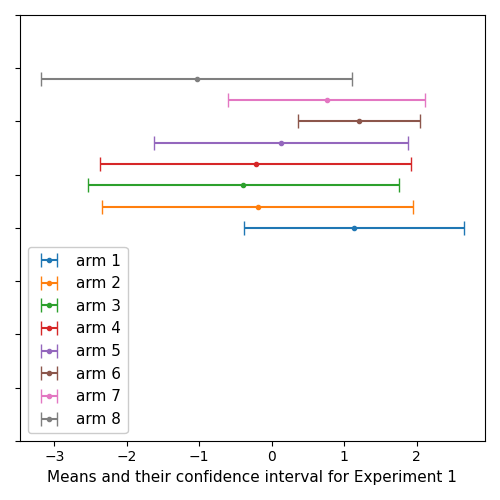

In [29]:
# Plotting the confidence interval for experiment 1

estimate = agen.reward_estimates[0,:]
radius = agen.r[0,:]

from scipy import stats


def plot_interval(i):
    interval = np.array([estimate[i]-radius[i], estimate[i]+radius[i]])
    ax.errorbar(estimate[i], i, xerr = (radius[i]), fmt ='o', markersize=3, capsize=5, label='arm ' + str(i+1))


fig, ax = plt.subplots(figsize=(5, 5))


for i in range(num_bandits):
    plot_interval(i)

ax.set_ylim(-10, 10)
ax.legend(loc='best', fontsize=11, framealpha=1, frameon=True)
ax.set_xlabel('Means and their confidence interval for Experiment 1', fontsize=11)
ax.yaxis.set_major_formatter(plt.NullFormatter())
fig.tight_layout();



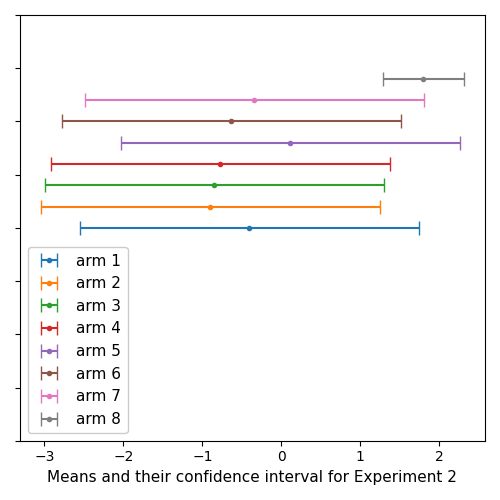

In [30]:
# Plotting the confidence interval for experiment 2

estimate = agen.reward_estimates[1,:]
radius = agen.r[1,:]

fig, ax = plt.subplots(figsize=(5, 5))


for i in range(num_bandits):
    plot_interval(i)

ax.set_ylim(-10, 10)

ax.legend(loc='best', fontsize=11, framealpha=1, frameon=True)
ax.set_xlabel('Means and their confidence interval for Experiment 2', fontsize=11)
ax.yaxis.set_major_formatter(plt.NullFormatter())
fig.tight_layout();

### 3.3 Values for weight parameter `c`

Design and test using an experiment using different values for `c` in `{0 1 2 3 4}` similar to what we earlier did. Write your code below for the experiment and plot the average reward and the average optimality ratio for various values of `c`. What value of `c` generates the maximum average reward over 1000 steps? What value of `c` leads to highest average optimality? Is your answer to the above two parts same? `[3 Marks]`

In [31]:
# Write your code for the experiment to test different values of weight parameters

def ucb_experiment(num_experiments=1000, num_steps=1000, num_actions=10,c= 1):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    # Initialize the agent
    agent = UCBAgent(np.zeros((num_experiments,num_actions)), c, num_steps)

    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))
    
    #Store the optimal actions for later use
    optimal = np.argmax(env.mean, axis=1)
    
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action(i)
        _, reward, _, _ = env.step(action)
        
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)
        
        # Store the average cumulative score and optimality of the current step
        scores[:,i+1] = scores[:,i] + reward
        avg_score = np.mean(scores[:,i+1]/(i+1))
        averages[i] = avg_score
        
        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[i] = current_optimality
    return optimality, averages

100%|██████████| 1000/1000 [00:00<00:00, 2339.31it/s]


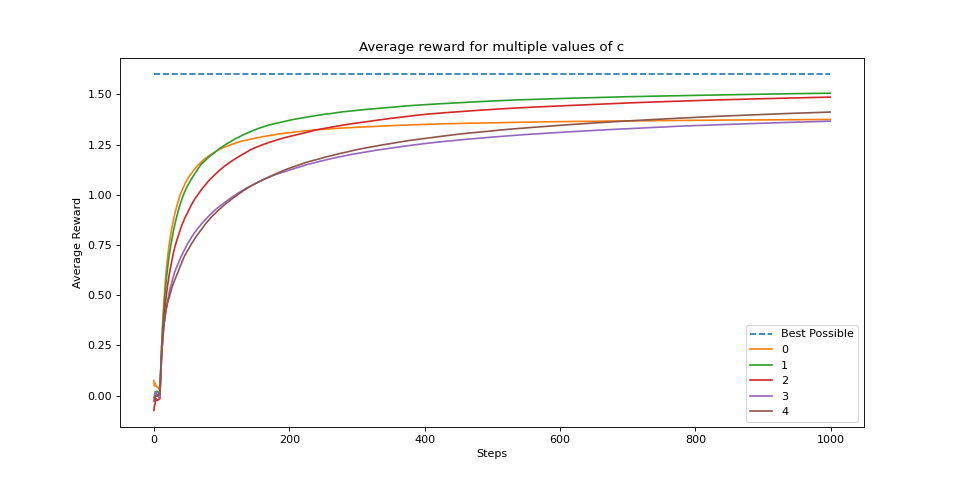

In [32]:
num_experiments = 1000
num_steps = 1000
num_actions = 10
cs = np.array([0, 1, 2, 3, 4])

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.6 for _ in range(num_steps)], linestyle='--') 


for c in cs:
    _, reward = ucb_experiment(num_experiments, num_steps, num_actions, c)
    plt.plot(reward)
    
plt.legend(["Best Possible"] + cs.tolist())
plt.title("Average reward for multiple values of c")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

100%|██████████| 1000/1000 [00:00<00:00, 2099.58it/s]


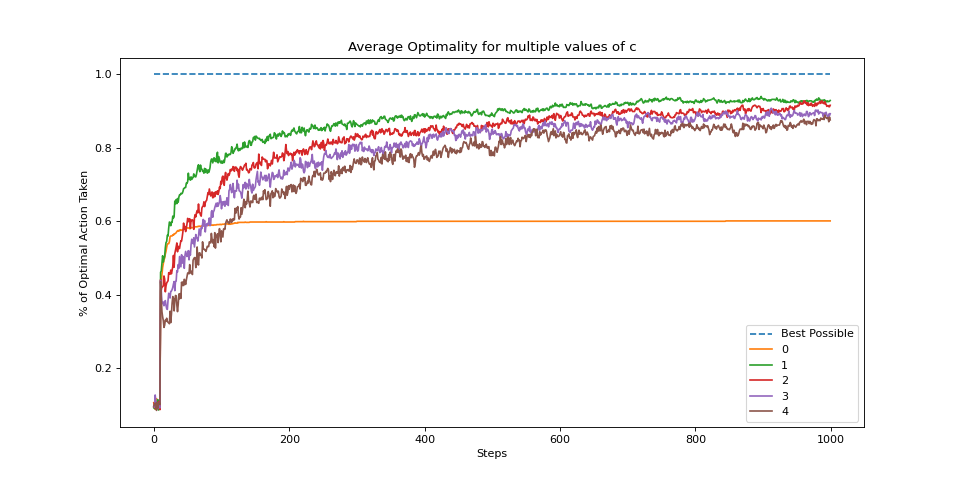

In [33]:
num_experiments = 1000
num_steps = 1000
num_actions = 10
cs = np.array([0, 1, 2, 3, 4])

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1 for _ in range(num_steps)], linestyle='--') 


for c in cs:
    optimality , reward = ucb_experiment(num_experiments, num_steps, num_actions, c)
    plt.plot(optimality)
    
plt.legend(["Best Possible"] + cs.tolist())
plt.title("Average Optimality for multiple values of c")
plt.xlabel("Steps")
plt.ylabel("% of Optimal Action Taken")
plt.show()

* We see the best reward and best optimality for **c = 1**
* In case of optimality, c = 2 performs comparable to c = 1. (But c = 1 is still better)

## Part 4: Thompson Sampling (TS)

Thompson Sampling uses a bayesian approach to track the belief over the parameters of reward distribution. Most of the above discussed approaches try to find a point estimates for the expected reward of each arm. On the other hand, a Bayesian learner tries to maintain a probability distribution that also accounts for uncertainity about the parameters of the reward distribution.  

### Posterior for Gaussian priors and Gaussian i.i.d. observations

In the course lectures we saw an illustration of TS for the Bernoulli bandit problem assuming a prior on the means of the reward distribution arising from a uniform or a beta distribution. Here we will explore a variation of the setting for the Gaussian reward distribution with known variance. The objective here would be to track the posterior of the unknown mean of the reward distributions assuming a gaussian prior over the mean.

We consider the special case when observations are generated from $\mathcal{N}(\mu,1)$, where $\mu$ is the single unknown mean reward parameter we are trying to learn. Assuming a $\mathcal{N}(\mu_0,\sigma_0)$ prior over the unknown true mean parameter $\mu$, we have the posterior of the belief distribution over $\mu$ after observing 1 reward sample $r$ from $\mathcal{N}(\mu,1)$ reward distribution is given by <br />

$\mathcal{N}\Big(\dfrac{\mu_0 + \sigma_0^2 r}{1 + \sigma_0^2}, \dfrac{\sigma_0^2}{1+\sigma_0^2}\Big) $ <br >

### 4.1 TS Agent

For this part realize an agent class that executes the TS Algorithm for the above discussed setting. `[7.5 Marks]`

In [34]:
# Thompson Sampling Agent

class TSAgent:
    def __init__(self, reward_estimates,stddev_estimates):
        self.num_bandits = reward_estimates.shape[1]
        self.num_experiments = reward_estimates.shape[0]
        
        self.action_count = np.ones(reward_estimates.shape)
        self.reward_estimates = reward_estimates
        self.stddev_estimates = stddev_estimates
    
    def get_action(self):
        # Sample from the gaussian distribution 
        samples = np.random.normal(self.reward_estimates, (self.stddev_estimates), size=self.reward_estimates.shape)
        action = argmax(samples)
        return action
        

    def update_estimates(self, reward, action):
        n = self.action_count[np.arange(self.num_experiments), action]
        prev_reward_estimates = self.reward_estimates[np.arange(self.num_experiments), action]
        
        # Update the reward estimates incementally
        self.reward_estimates[np.arange(self.num_experiments), action] = inc_avg(prev_reward_estimates,reward,n)
        # Update the standard deviation estimates
        self.stddev_estimates[np.arange(self.num_experiments), action] = 1/(n+1)

### 4.2 Testing the agent

Observe how this TS Agent behaves on the environment assuming an initial prior of $\mathcal{N}(0,1)$ over the mean of all the arms. For this, try to generate some animations as before to see how the agent estimates the values for each action, as well as the real values provided by the environment. Remember that the agent doesn't have access to that information. For this setting try and plot the posterior over the reward for each arm rather than just the point estimate. Write your code below `[7.5 Marks]`

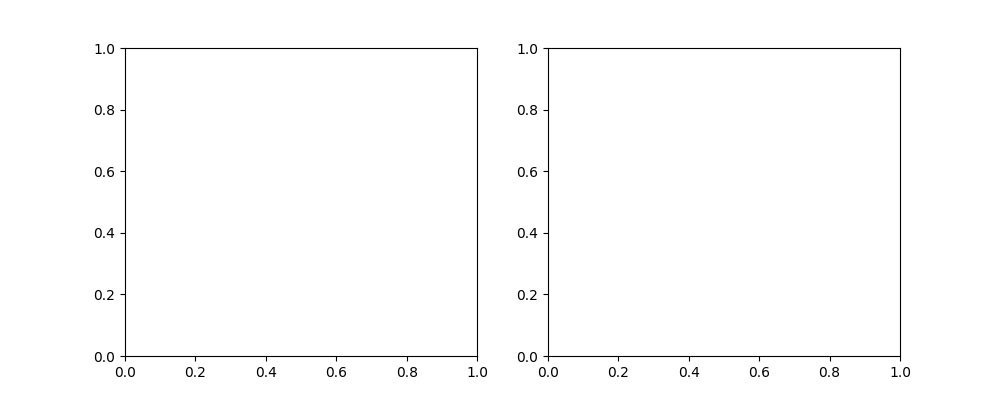

In [35]:
# Write your code for testing the TS agent

num_experiments = 2
num_bandits = 8
num_steps = 2000
means = np.random.normal(size=(num_experiments, num_bandits))
stdev = np.ones((num_experiments, num_bandits))

env = ArmedBanditsEnv(means, stdev)

agen = TSAgent(np.zeros((num_experiments,num_bandits)), np.ones((num_experiments,num_bandits)))

# Code for plotting the interaction
fig, axs = plt.subplots(1, num_experiments, figsize=(10, 4))
x_pos = np.arange(num_bandits)

def init():
    for i in range(num_experiments):
        init_ax(i)
        
    
def init_ax(i):
    ax = axs[i]
    ax.clear()
    ax.set_ylim(-4, 4)
    ax.set_xlim(-0.5, num_bandits-.5)
    ax.set_xlabel('Actions', fontsize=14)
    ax.set_ylabel('Value', fontsize=14)
    ax.set_title(label='Estimated vs. Real values', fontsize=15)
    ax.plot(x_pos, env.mean[i], marker='D', linestyle='', alpha=0.8, color='r', label='Real Values')
    ax.axhline(0, color='black', lw=1)
    
def step(g):
    action = agen.get_action()
    _, reward, _, _ = env.step(action)
    agen.update_estimates(reward, action)
    for i in range(num_experiments):
        ax = axs[i]
        # Plot the estimated values from the agent compared to the real values
        estimates = agen.reward_estimates[i]
        init_ax(i)
        values = ax.bar(x_pos, estimates, align='center', color='blue', alpha=0.4, label='Estimated Values')
        ax.legend()
    
anim = FuncAnimation(fig, func=step, frames=np.arange(num_steps), init_func=init, interval=10, repeat=True, blit=True)
plt.show()

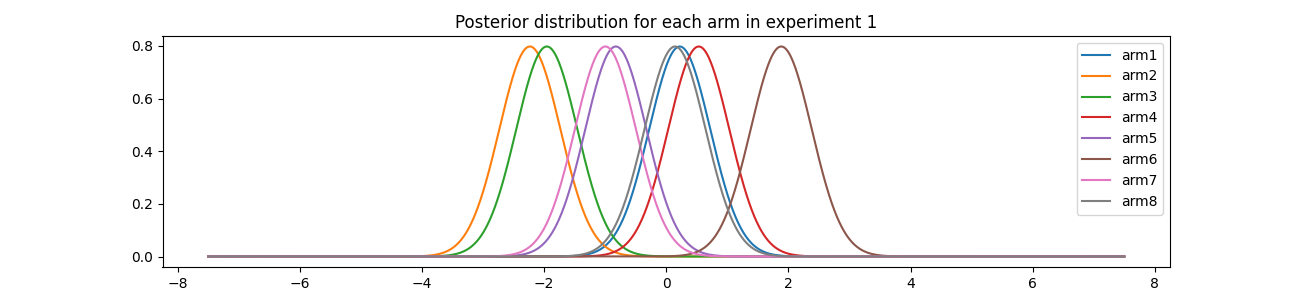

In [36]:
# Plotting the posterior for each arm for experiment 1

mean1 = agen.reward_estimates[0,:]
stddev1 = agen.stddev_estimates[0,:]

from scipy.stats import norm

plt.figure(figsize=(13, 3))

x = np.arange(-7.5, 7.5, 0.001)

for i in range(num_bandits):
    plt.plot(x, norm.pdf(x, mean1[i], stddev1[i]), label = 'arm' + str(i+1))

plt.title('Posterior distribution for each arm in experiment 1')
plt.legend()
plt.show()

C:\Users\Administrator\AppData\Local\Temp\ipykernel_17656\3810204622.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(13, 3))


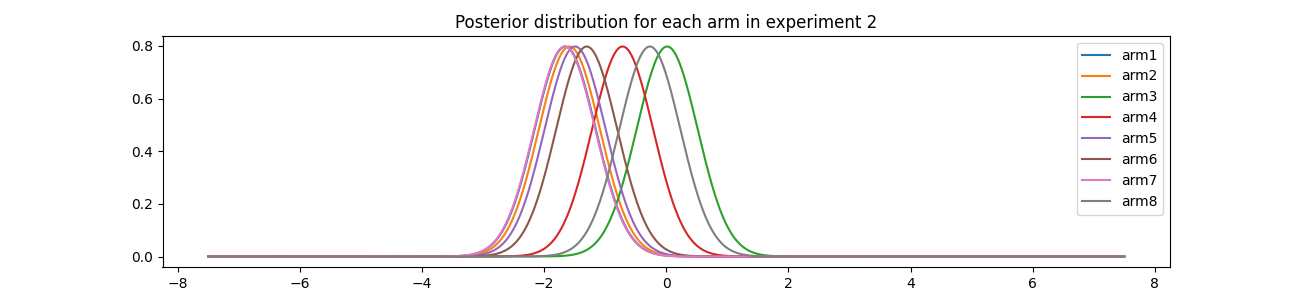

In [37]:
mean1 = agen.reward_estimates[1,:]
stddev1 = agen.stddev_estimates[1,:]

plt.figure(figsize=(13, 3))

x = np.arange(-7.5, 7.5, 0.001)

for i in range(num_bandits):
    plt.plot(x, norm.pdf(x, mean1[i], stddev1[i]), label = 'arm' + str(i+1))

plt.title('Posterior distribution for each arm in experiment 2')
plt.legend()
plt.show()

### 4.3 Optimality Analysis

For the TS agent, plot the % of Optimal Action vs episodes averaged over 10000 randomized experiments.

In [38]:
# Write your code for plotting the optimality ratio vs episodes

def ts_experiment(num_experiments=10000, num_steps=1000, num_actions=10):
    # Initialize the environment
    env = ArmedBanditsGaussian(num_experiments, num_actions)
    # Initialize the agent
    agent = TSAgent(np.zeros((num_experiments,num_actions)), np.ones((num_experiments,num_actions)))

    # Store the scores and averages for later plotting
    averages = np.zeros((num_steps))
    optimality = np.zeros((num_steps))
    scores = np.zeros((num_experiments, num_steps+1))
    
    #Store the optimal actions for later use
    optimal = np.argmax(env.mean, axis=1)
    
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        _, reward, _, _ = env.step(action)
        
        # Update the agent estimates with the previously observed rewards
        agent.update_estimates(reward, action)
        
        # Store the average cumulative score and optimality of the current step
        scores[:,i+1] = scores[:,i] + reward
        avg_score = np.mean(scores[:,i+1]/(i+1))
        averages[i] = avg_score
        
        # Get optimal actions from the environment
        current_optimality = np.mean(action == optimal)
        optimality[i] = current_optimality
    return optimality, averages

100%|██████████| 1000/1000 [00:06<00:00, 145.92it/s]


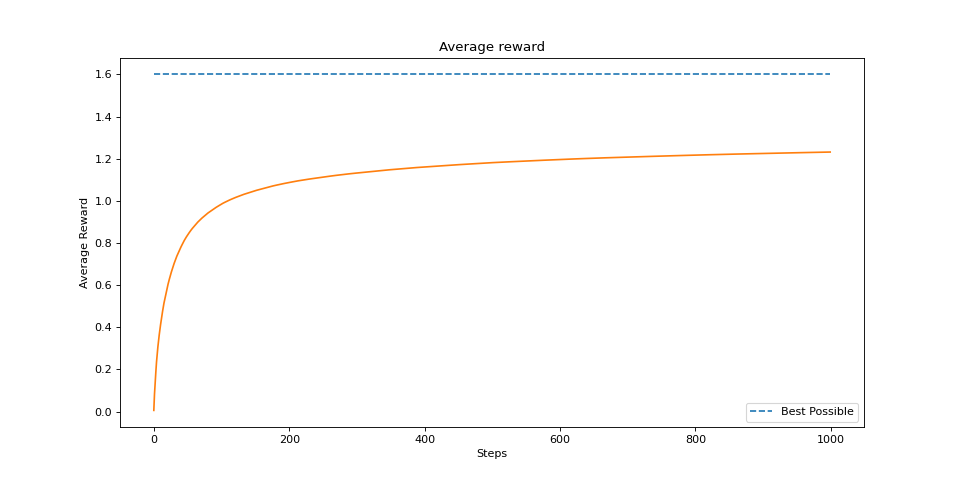

In [39]:
num_experiments = 10000
num_steps = 1000
num_actions = 10

plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1.6 for _ in range(num_steps)], linestyle='--') 


optimality, reward = ts_experiment(num_experiments, num_steps, num_actions)
plt.plot(reward)
    
plt.legend(["Best Possible"])
plt.title("Average reward")
plt.xlabel("Steps")
plt.ylabel("Average Reward")
plt.show()

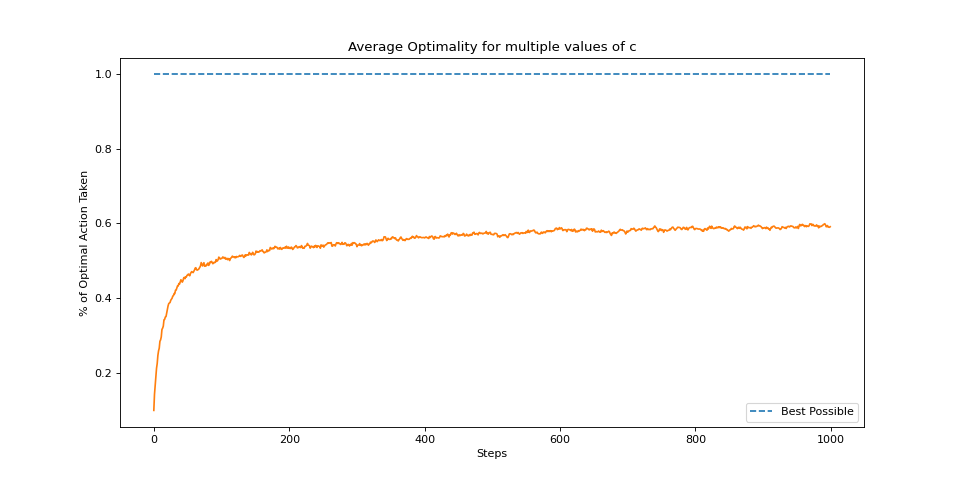

In [40]:
plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
plt.plot([1 for _ in range(num_steps)], linestyle='--') 

plt.plot(optimality)
    
plt.legend(["Best Possible"])
plt.title("Average Optimality for multiple values of c")
plt.xlabel("Steps")
plt.ylabel("% of Optimal Action Taken")
plt.show()

## Part 5: Regret Plots and Comparison

In the lecture we defined `Regret` as $R(T) = \sum_{t=1}^T [\mu^* - \mu(a_t)]$. It represents how much the algorithm 'regrets' not knowing the best arm in advance. 

### 5.1 Regret Plots

Till now we have explored multiple learning strategies to solve the MAB problem. Write your code below to plot the average regret over 10000 experiments for the best cases (the case that reaches the highest optiimality action ratio) of all the above algorithms (discussed in Part 1-4 also include greedy and epsilon-greedy methods). Simulate the experiments for 1000 steps for a 10 arm MAB setting.     `[5 Marks]`

In [41]:
# Write your code for the experiment here

num_experiments = 10000
num_steps = 1000
num_actions = 10

env = ArmedBanditsGaussian(num_experiments, num_actions)

greedy = EpsilonGreedyAgent(np.zeros((num_experiments,num_actions)), 0) # epsilon greedy is greedy with epsilon = 0
e_greedy = EpsilonGreedyAgent(np.zeros((num_experiments,num_actions)), 0.1)
tve_greedy = TimeVaryingEpsilonGreedyAgent(np.zeros((num_experiments,num_actions)), 0.5, 0, num_steps)
sae_agent = SEA(np.zeros((num_experiments,num_actions)), num_steps, 1)
ucb_agent = UCBAgent(np.zeros((num_experiments,num_actions)), 1, num_steps)
ts_agent = TSAgent(np.zeros((num_experiments,num_actions)), np.ones((num_experiments,num_actions)))



In [42]:
# Regret functions for all the algorithms

def e_greedyregret(env, agent, num_experiments=1000, num_steps=1000, num_actions=10,epsilon=0.1):

    regret = np.zeros((num_experiments, num_steps+1))
    optimal = np.argmax(env.mean, axis=1)
    
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        _, reward, _, _ = env.step(action)
        agent.update_estimates(reward, action)

        regret[:,i+1] = regret[:,i] + env.mean[np.arange(num_experiments), optimal] - env.mean[np.arange(num_experiments), action]
    
    return np.mean(regret, axis=0)

# --------------------------------------------------------------------------------------------------------------------------------------------- #

def tve_greedyregret(env, agent, num_experiments=1000, num_steps=1000, num_actions=10,  epsilon_0 = 0.1, decay = 0):

    regret = np.zeros((num_experiments, num_steps+1))
    optimal = np.argmax(env.mean, axis=1)
    
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        _, reward, _, _ = env.step(action)
        agent.update_estimates(reward, action)

        regret[:,i+1] = regret[:,i] + env.mean[np.arange(num_experiments), optimal] - env.mean[np.arange(num_experiments), action]
    
    return np.mean(regret, axis=0)

# --------------------------------------------------------------------------------------------------------------------------------------------- #

def sea_regret(env, agent, num_experiments=1000, num_steps=1000, num_actions=10, c = np.sqrt(2)):

    ac = []

    optimal = np.argmax(env.mean, axis=1)
    for k in range(num_experiments):
        ac.append([0])

    def s_step(num_steps):
        for i in tqdm(range(num_experiments)):
            s = 0
            agent.reward_estimates = np.zeros((num_experiments,num_actions))
            agent.active = np.ones(agent.num_bandits)
            agent.action_count = np.zeros(agent.num_bandits)
            r = 0

            while (s < num_steps):
                reward, step = env.SAE_step(agent.active, i, 0)
                agent.update_estimates(reward, i)
                agent.eliminate_bandit(i)
                
                for j in range(len(reward)):
                    if(s + j <= num_steps and reward[j]!=0):
                        r = reward[j] + r

                    if(reward[j]!=0):
                        ac[i].append(ac[i][-1] + env.mean[i][(optimal[i])] -  env.mean[i][j]) 
                        
                s = step + s

    s_step(num_steps)

    ac1 = []
    for i in range(len(ac)):
        ac1.append(ac[i][:num_steps+1])

    ac1 = np.array(ac1)
    return np.mean(ac1, axis=0)

# --------------------------------------------------------------------------------------------------------------------------------------------- #    

def ucb_regret(env, agent, num_experiments=1000, num_steps=1000, num_actions=10,c= 1):

    regret = np.zeros((num_experiments, num_steps+1))
    optimal = np.argmax(env.mean, axis=1)
    
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action(i)
        _, reward, _, _ = env.step(action)
        agent.update_estimates(reward, action)

        regret[:,i+1] = regret[:,i] + env.mean[np.arange(num_experiments), optimal] - env.mean[np.arange(num_experiments), action]
    
    return np.mean(regret, axis=0)

# --------------------------------------------------------------------------------------------------------------------------------------------- #

def ts_regret(env, agent, num_experiments=1000, num_steps=1000, num_actions=10):

    regret = np.zeros((num_experiments, num_steps+1))
    optimal = np.argmax(env.mean, axis=1)
    
    for i in tqdm(range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        _, reward, _, _ = env.step(action)
        agent.update_estimates(reward, action)

        regret[:,i+1] = regret[:,i] + env.mean[np.arange(num_experiments), optimal] - env.mean[np.arange(num_experiments), action]
    
    return np.mean(regret, axis=0)



100%|██████████| 1000/1000 [00:06<00:00, 159.24it/s]


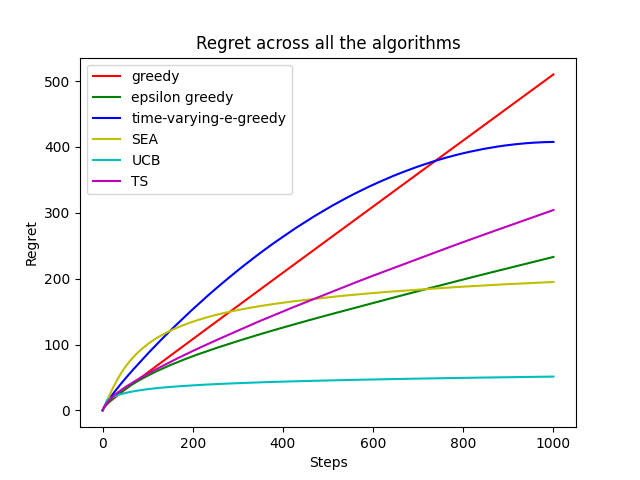

In [43]:
greedy_regret_ = e_greedyregret(env, greedy, num_experiments, num_steps, num_actions,epsilon=0)
e_greedy_regret_ = e_greedyregret(env, e_greedy, num_experiments, num_steps, num_actions,epsilon=0.1)
tve_greedy_regret_ = tve_greedyregret(env, tve_greedy, num_experiments, num_steps, num_actions,epsilon_0 = 0.5, decay = 0)
sae_regret_ = sea_regret(env, sae_agent, 1000, c = 1)
ucb_regret_ = ucb_regret(env, ucb_agent, num_experiments, num_steps, num_actions,c= 1)
ts_regret_ = ts_regret(env, ts_agent, num_experiments, num_steps, num_actions)

X = np.arange(num_steps+1)

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

fig, ax = plt.subplots()

ax.plot(X, greedy_regret_, color='r', label='greedy')
ax.plot(X, e_greedy_regret_, color='g', label='epsilon greedy')
ax.plot(X, tve_greedy_regret_, color='b', label='time-varying-e-greedy')
ax.plot(X, sae_regret_, color='y', label='SEA')
ax.plot(X, ucb_regret_, color='c', label='UCB')
ax.plot(X, ts_regret_, color='m', label='TS')

legend_without_duplicate_labels(ax)

plt.xlabel("Steps")
plt.ylabel("Regret")
plt.title("Regret across all the algorithms")

plt.show()

### 5.2 Based on the analysis and plots generated, answer the following questions and describe in detail

**5.2.1** What do you observe? How do regrets evolve for different methods? `[3 Marks]`

**5.2.2** Which agent/algorithm performs the best for the given setting? `[2 Marks]`

**Answers**  
5.2.1   
For Greedy, the Regret increases linearly and rapidly.  
For TS and epsilon greedy, the Regret seems to increase linearly but thhe slope is less than greedy. (Epsilon greedy progresses slower than TS)  
For time varying epsilon greedy, regret increses rapidly for initial steps then the increase slows down.  
For SEA too, the regret increases rapidly. But at the later stages it increases very slowly.  
The least regret we get is for UCB. The regret increases initially but later it does not change at all.

5.2.2  
UCB performs the best in the given setting.

### 5.3 Lower Bounds on regret

Repeat the above part 5.1 for a two bandit setting but instead of generating the true means for the bandit experiments using the gaussian distribution as used in the ArmedBanditsGaussian, use the true means specified below. 

**Case 1**: $\mu_1 = 1/60, \mu_2 = 0$ <br />
**Case 2**: $\mu_1 = 2/60, \mu_2 = 1/60$

Along with the regret for the algorithms also plot the regret lower bound for the two cases, the bound is given by the theorem below. `[5 Marks]`

`Theorem:` For any policy $\pi, \exists \mu = (\mu_1,\cdots,\mu_k) \in [0,1]^k$, with $P_{\nu_\mu} = (P_1,\cdots,P_k), P_j \sim \mathcal{N}(\mu_j,1)$ such that $R_t(\pi,\nu_\mu) \geq \frac{1}{27}\sqrt{(k-1)t}$ 

100%|██████████| 1000/1000 [00:02<00:00, 385.36it/s]


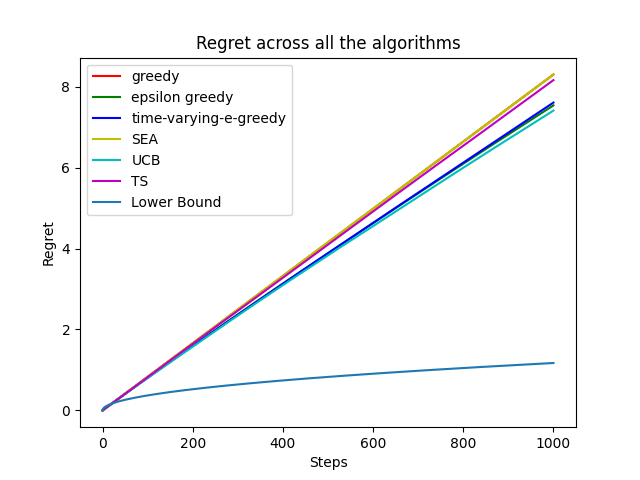

In [44]:
# write your code for this part here

# Plotting for CASE 1

num_experiments = 10000
num_steps = 1000
num_actions = 2

means1 = np.array(np.full((num_experiments,num_actions), [1/60, 0]))
stdev1 = np.ones((num_experiments, num_actions))

env = ArmedBanditsEnv(means1, stdev1)

greedy = EpsilonGreedyAgent(np.zeros((num_experiments,num_actions)), 0) # epsilon greedy is greedy with epsilon = 0
e_greedy = EpsilonGreedyAgent(np.zeros((num_experiments,num_actions)), 0.1)
tve_greedy = TimeVaryingEpsilonGreedyAgent(np.zeros((num_experiments,num_actions)), 0.1, 0, num_steps)
sae_agent = SEA(np.zeros((num_experiments,num_actions)), num_steps, 1)
ucb_agent = UCBAgent(np.zeros((num_experiments,num_actions)), 1, num_steps)
ts_agent = TSAgent(np.zeros((num_experiments,num_actions)), np.ones((num_experiments,num_actions)))

greedy_regret_ = e_greedyregret(env, greedy, num_experiments, num_steps, num_actions,epsilon=0)
e_greedy_regret_ = e_greedyregret(env, e_greedy, num_experiments, num_steps, num_actions,epsilon=0.1)
tve_greedy_regret_ = tve_greedyregret(env, tve_greedy, num_experiments, num_steps, num_actions,epsilon_0 = 0.1, decay = 0)
sae_regret_ = sea_regret(env, sae_agent, 1000, num_actions = 2, c = 1)
ucb_regret_ = ucb_regret(env, ucb_agent, num_experiments, num_steps, num_actions,c= 1)
ts_regret_ = ts_regret(env, ts_agent, num_experiments, num_steps, num_actions)

X = np.arange(num_steps+1)

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

fig, ax = plt.subplots()

ax.plot(X, greedy_regret_, color='r', label='greedy')
ax.plot(X, e_greedy_regret_, color='g', label='epsilon greedy')
ax.plot(X, tve_greedy_regret_, color='b', label='time-varying-e-greedy')
ax.plot(X, sae_regret_, color='y', label='SEA')
ax.plot(X, ucb_regret_, color='c', label='UCB')
ax.plot(X, ts_regret_, color='m', label='TS')
ax.plot(X, (1/27)*np.sqrt((num_actions - 1)*X), label = "Lower Bound")

legend_without_duplicate_labels(ax)

plt.xlabel("Steps")
plt.ylabel("Regret")
plt.title("Regret across all the algorithms")

plt.show()



100%|██████████| 1000/1000 [00:03<00:00, 312.91it/s]


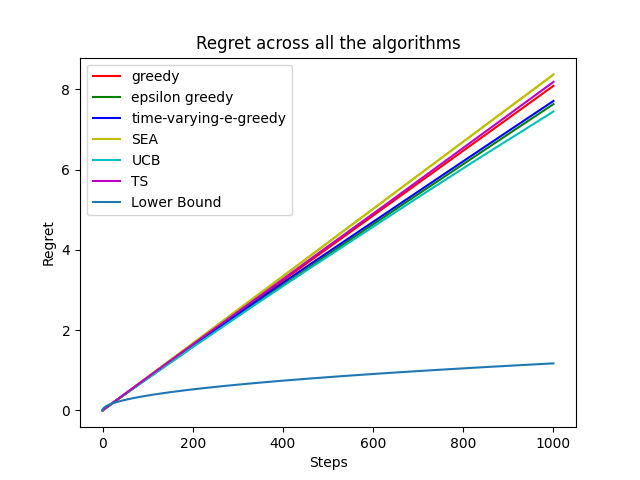

In [45]:
# Plotting for CASE 2

num_experiments = 10000
num_steps = 1000
num_actions = 2

means1 = np.array(np.full((num_experiments,num_actions), [2/60, 1/60]))
stdev1 = np.ones((num_experiments, num_actions))

env = ArmedBanditsEnv(means1, stdev1)

greedy = EpsilonGreedyAgent(np.zeros((num_experiments,num_actions)), 0)
# epsilon greedys is greedys with epsilon = 0
e_greedy = EpsilonGreedyAgent(np.zeros((num_experiments,num_actions)), 0.1)
tve_greedy = TimeVaryingEpsilonGreedyAgent(np.zeros((num_experiments,num_actions)), 0.1, 0, num_steps)
sae_agent = SEA(np.zeros((num_experiments,num_actions)), num_steps, 1)
ucb_agent = UCBAgent(np.zeros((num_experiments,num_actions)), 1, num_steps)
ts_agent = TSAgent(np.zeros((num_experiments,num_actions)), np.ones((num_experiments,num_actions)))

greedy_regret_ = e_greedyregret(env, greedy, num_experiments, num_steps, num_actions,epsilon=0)
e_greedy_regret_ = e_greedyregret(env, e_greedy, num_experiments, num_steps, num_actions,epsilon=0.1)
tve_greedy_regret_ = tve_greedyregret(env, tve_greedy, num_experiments, num_steps, num_actions,epsilon_0 = 0.1, decay = 0)
sae_regret_ = sea_regret(env, sae_agent, num_experiments=1000, num_actions = 2, c = 1)
ucb_regret_ = ucb_regret(env, ucb_agent, num_experiments, num_steps, num_actions,c= 1)
ts_regret_ = ts_regret(env, ts_agent, num_experiments, num_steps, num_actions)

X = np.arange(num_steps+1)

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))

fig, ax = plt.subplots()

ax.plot(X, greedy_regret_, color='r', label='greedy')
ax.plot(X, e_greedy_regret_, color='g', label='epsilon greedy')
ax.plot(X, tve_greedy_regret_, color='b', label='time-varying-e-greedy')
ax.plot(X, sae_regret_, color='y', label='SEA')
ax.plot(X, ucb_regret_, color='c', label='UCB')
ax.plot(X, ts_regret_, color='m', label='TS')
ax.plot(X, (1/27)*np.sqrt((num_actions - 1)*X), label = "Lower Bound")

legend_without_duplicate_labels(ax)

plt.xlabel("Steps")
plt.ylabel("Regret")
plt.title("Regret across all the algorithms")

plt.show()


**5.3.1** How does the lower bound regret curve compare to the other algorithms regret?  
**5.3.2** In witch of the cases the emperical regret is strictly grater than the lower bound? 

**Answers**  
5.3.1 The lower bound curve is exponential (we have negative exponent in the equation) while the others seem to be linear for the given setting. The lower bound curve is fairly below the other algorithms' regret.

5.3.2 In all the cases, the emperical regret is strictly greater than lower bound.

## Part 6: Hoeffding Inequality

$\mathbb{P}(|\bar{\mu}-\mu|\geq \epsilon) \leq 2\exp{(-2\epsilon^2N)} $

Hoeffding's inequality provides an upper bound on the probability that the estimated mean of a bounded independent random variables deviates from its true value by more than a certain amount $\epsilon$. Hoeffding inquality is extremely widely used in machine learning theory. The intuition for this result is very simple. We have a bunch of random variables. We know that when we average them up, we should usually get something close to the expected value. Hoeffding simply quantifies “usually” and “close” for us.

### 6.1 Monte Carlo Simulations

For this part run monte carlo simulations to verify the inequality. Generate $N$ samples from a given distribution with known $\mu$. For given a $\epsilon$, plot the emperical probabilty of deviating from the mean by more than  $\epsilon$ vs $N$ averaged over multiple experiments along with the plot of upper bound of the Hoeffding inequality for the following cases in seperate figures:

1) Binomial Distribution with $p = 0.5, \epsilon = 0.25$ for $N\in [1,100]$
2) Binomial Distribution with $p = 0.5, \epsilon = 0.05$ for $N\in [1,1000]$
3) Binomial Distribution with $p = 0.1, \epsilon = 0.25$ for $N\in [1,100]$
4) Binomial Distribution with $p = 0.1, \epsilon = 0.05$ for $N\in [1,1000]$ 
5) Beta Distribution with $\alpha = 1, \beta = 1, \epsilon = 0.25$ for $N\in [1,100]$
6) Beta Distribution with $\alpha = 2, \beta = 5, \epsilon = 0.05$ for $N\in [1,1000]$

`[7.5 Marks]`

In [46]:
# write your code for this part here

def MonteCarloSimulation_bernoulli(num_experiments, N, epsilon, p):
    cum_means = np.zeros((num_experiments, N))
    X = np.random.binomial(1, p, (num_experiments, N))
    for i in range(N):
        x = X[:, :i+1]
        mean = np.mean(x, axis = 1)
        cum_means[:,i] = mean
    deviation = np.where((np.absolute(cum_means - p) >= epsilon), 1, 0)

    Y = np.mean(deviation, axis = 0)

    plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
    x = np.arange(N)
    plt.plot(x, Y, label = "Monte Carlo")
    plt.plot(x, 2 * np.exp( -2 * epsilon * epsilon * x), label = "Hoeffding Inequality")

    plt.title("Probability of deviation vs the number of steps")
    plt.legend()
    plt.xlabel("Number of Steps")
    plt.ylabel("Probability of deviation")
    plt.show()

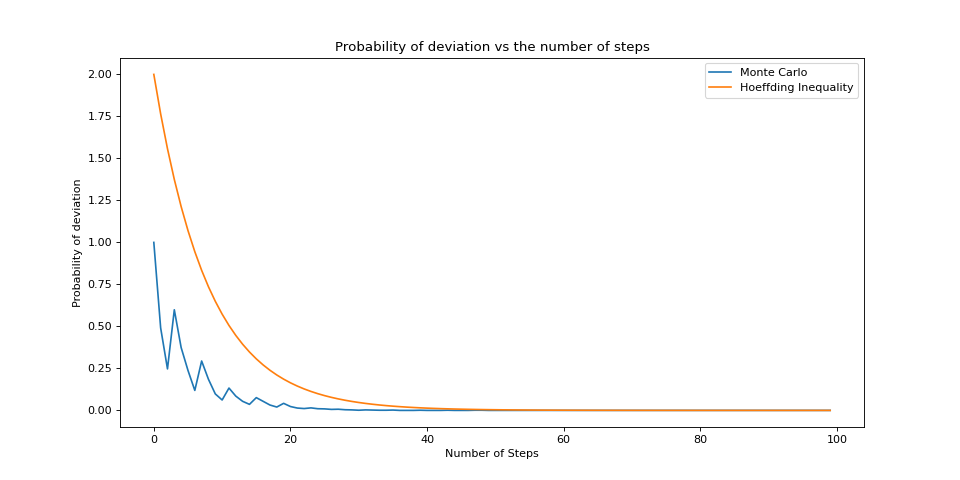

In [47]:
MonteCarloSimulation_bernoulli(1000, 100, 0.25, 0.5)

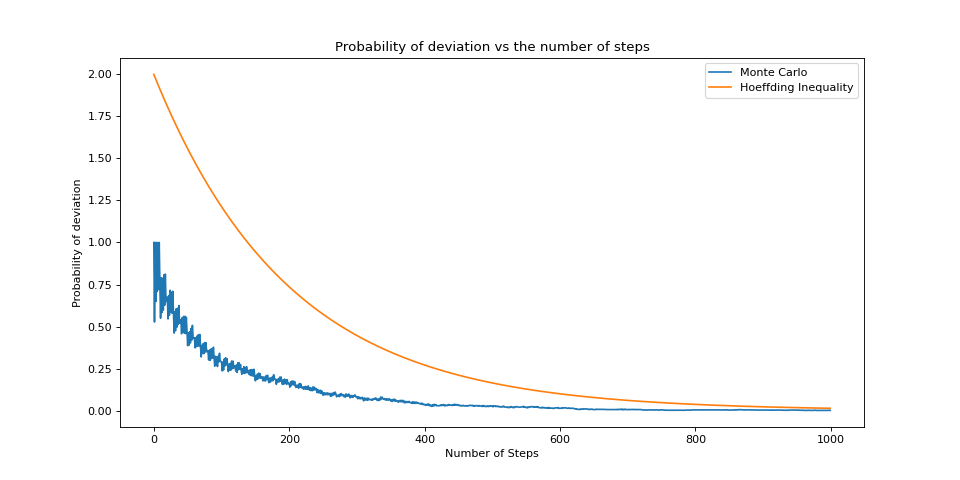

In [48]:
MonteCarloSimulation_bernoulli(1000, 1000, 0.05, 0.5)

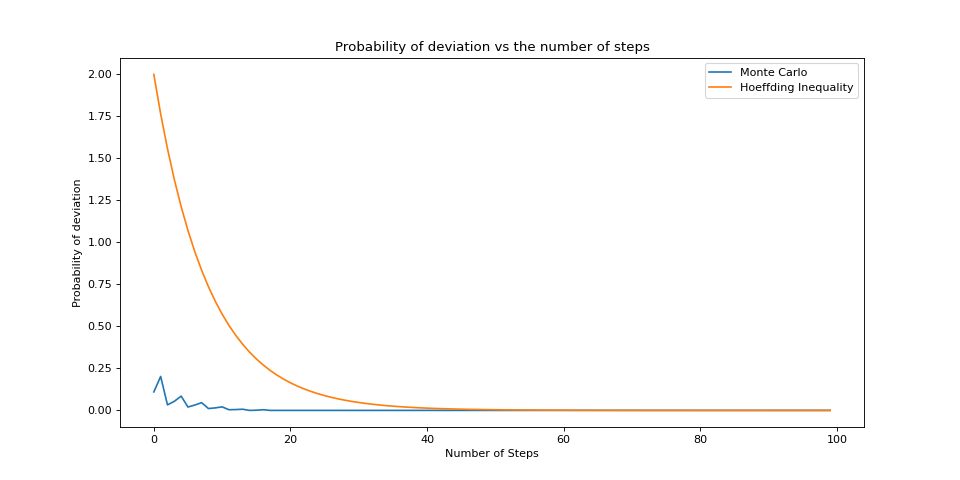

In [49]:
MonteCarloSimulation_bernoulli(1000, 100, 0.25, 0.1)

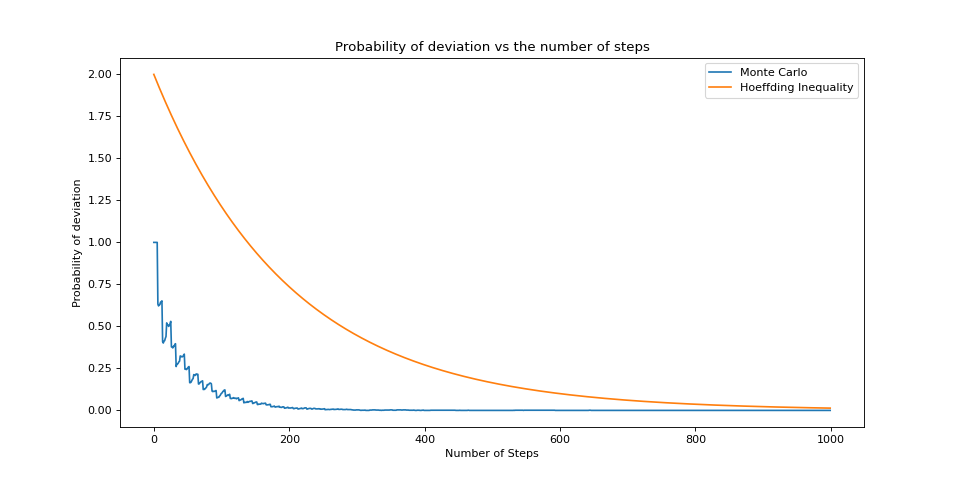

In [50]:
MonteCarloSimulation_bernoulli(1000, 1000, 0.05, 0.1)

In [52]:
def MonteCarloSimulation_beta(num_experiments, N, epsilon,alpha, beta):
    p = alpha/(alpha + beta)
    cum_means = np.zeros((num_experiments, N))
    X = np.random.beta(alpha, beta, (num_experiments, N))
    for i in range(N):
        x = X[:, :i+1]
        mean = np.mean(x, axis = 1)
        cum_means[:,i] = mean
    deviation = np.where((np.absolute(cum_means - p) >= epsilon), 1, 0)

    Y = np.mean(deviation, axis = 0)

    plt.figure(figsize=(12,6), dpi=80, facecolor='w', edgecolor='k')
    x = np.arange(N)
    plt.plot(x, Y, label = "Monte Carlo")
    plt.plot(x, 2 * np.exp( -2 * epsilon * epsilon * x), label = "Hoeffding Inequality")

    plt.title("Probability of deviation vs the number of steps")
    plt.legend()
    plt.xlabel("Number of Steps")
    plt.ylabel("Probability of deviation")
    plt.show()

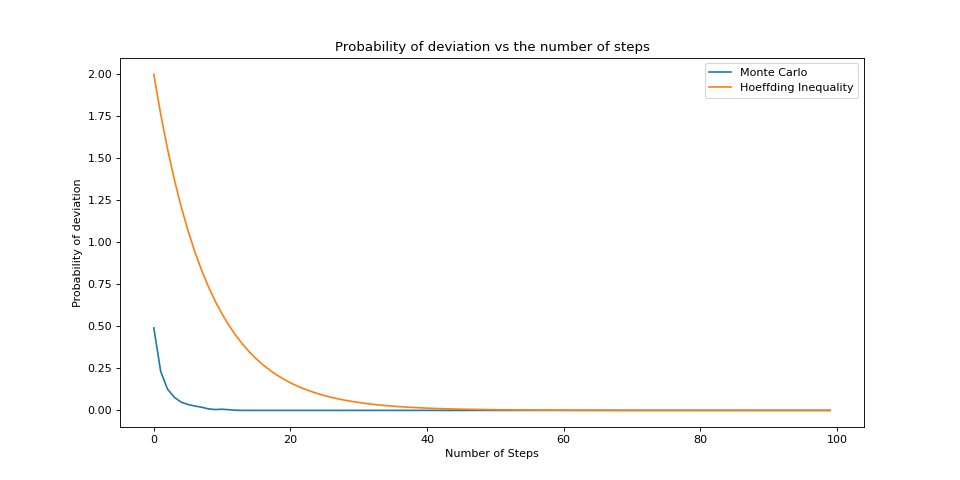

In [53]:
MonteCarloSimulation_beta(1000, 100, 0.25, 1, 1)

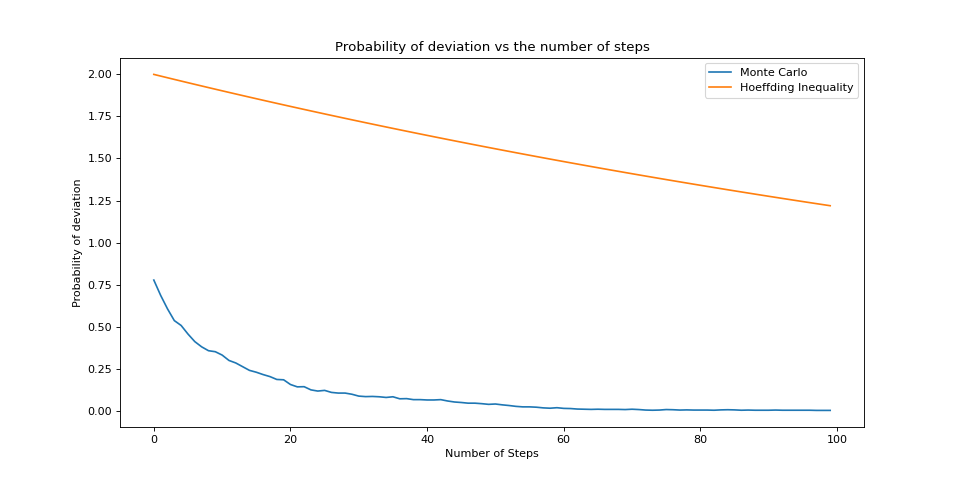

In [54]:
MonteCarloSimulation_beta(1000, 100, 0.05, 2, 5)

### 6.2 Based on the plots generated answer the following questions:
**6.2.1** For what value of $p=\{0.1,0.5\}$ for the Binomial distribution the upper bound is tighter than the other? <br />
**6.2.2** For the Binomial distribution with $p=0.9$ will Hoeffding inequality be loose or tight?

`[2.5 Marks]`

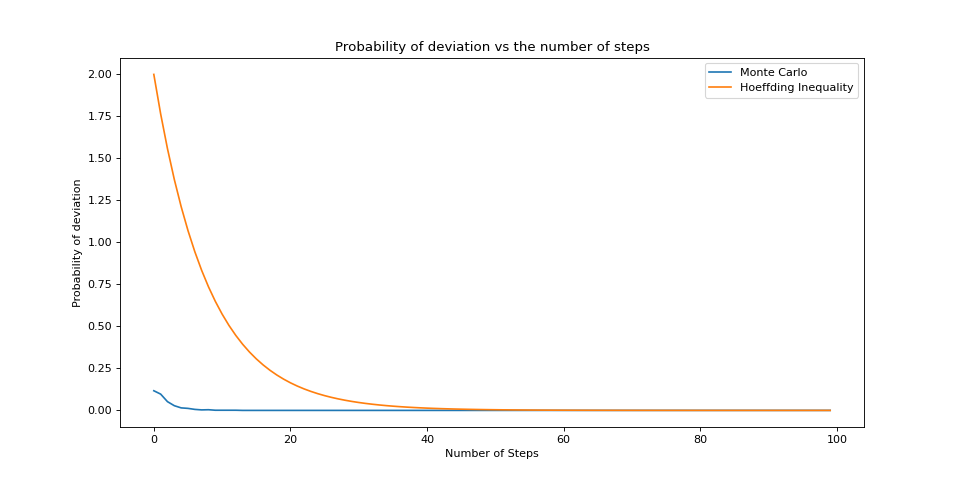

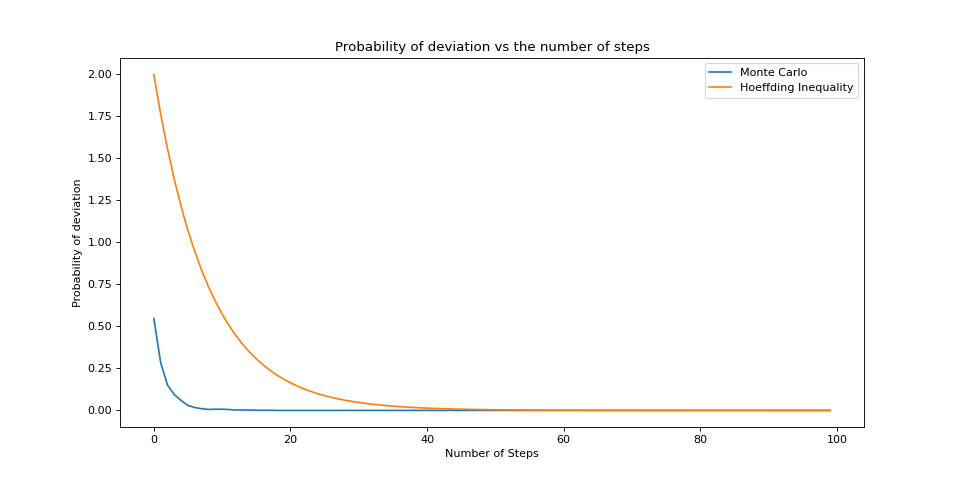

In [55]:
# 6.2.1

MonteCarloSimulation_beta(1000, 100, 0.25, 1, 0.1)
MonteCarloSimulation_beta(1000, 100, 0.25, 1, 0.5)


**6.2.1** For p = 0.1, we see a tighter bound.


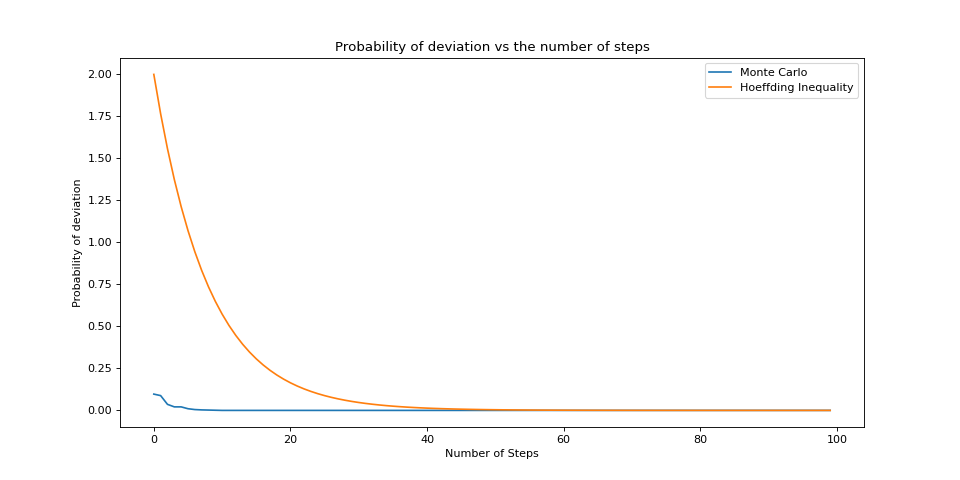

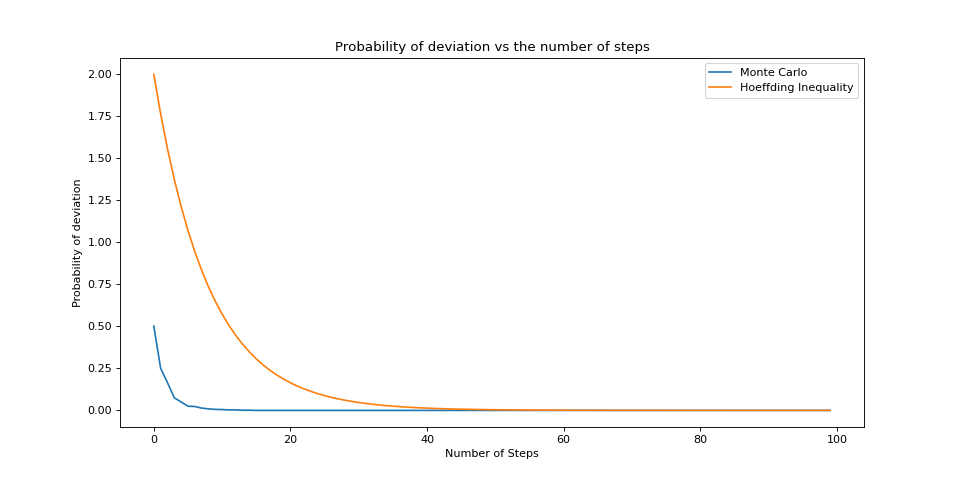

In [56]:
# 6.2.2

MonteCarloSimulation_beta(1000, 100, 0.25, 1, 0.1)
MonteCarloSimulation_beta(1000, 100, 0.25, 1, 0.9)

**6.2.2** For p = 0.9, the bound is **loose** as compared to p = 0.1  
But the bound seems tighter than p = 0.5

# Part 7: Failure of Greedy Algorithm

### 7.1 Bernoulli Bandits
Create an ArmBanditBernoulli class, that simulates MAB problem for the bernaulli bandit similar to ArmBanditEnv class. Using the calss simulate the following part. `[2 Marks]`

In [57]:
# write your code for this part here

class ArmedBanditsBernoulli():
    """
    The k-Armed Bandit Environment
    Initialization requires an array of length equals to k, where each item is
    a function which samples from a specified distribution.
    """
    
    def __init__(self, num_experiments ,p):
        
        self.num_experiments = num_experiments
        self.p = np.array(np.full((num_experiments,len(p)), p))

        
    def step(self, action):
        # Sample from the specified bandit using it's prior distribution
        reward = np.random.binomial(1, self.p)

        reward = reward[np.arange(self.num_experiments), action]
        
        # Return a constant state of 0. Our environment has no terminal state
        observation, done, info = 0, False, dict()
        return observation, reward, done, info
    
    def reset(self):
        return 0
        
    def render(self, mode='human', close=False):
        pass
    
    def _seed(self, seed=None):
        self.np_random, seed = seeding.np.random(seed)
        return [seed]
    
    def close(self):
        pass



### 7.2 Two arm Bernoulli Bandit simulation
Consider a Bernoulli bandit with two arms and means $\mu_1 = 0.5$ and $\mu_2 = 0.6$

**7.2.1** Using a horizon of $T = 100$, run $1000$ simulations of your implementation of Greedy algorithm on the Bernoulli bandit above and record the (random) pseudo regret, $R(T) = \sum_{t=1}^T [\mu^* - \mu(a_t)]$, in each simulation. Plot the results uing a histogram and explain the results in the figure. `[3 Marks]`

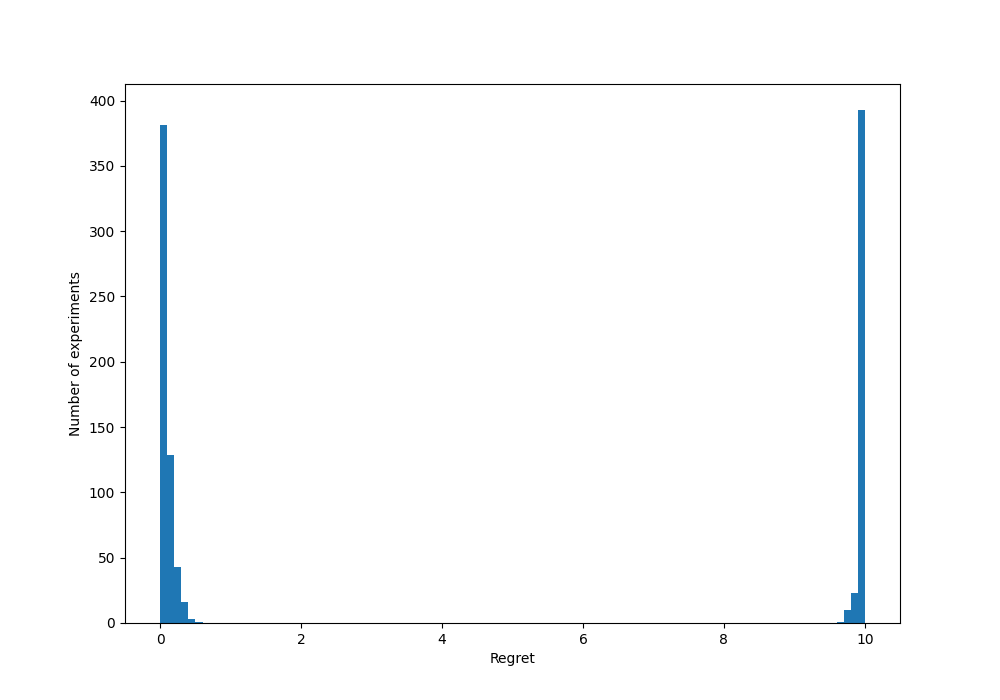

In [58]:
num_experiments = 1000
num_actions = 2


def followthelead_regret(num_experiments=1000, num_steps=1000, num_actions=10):
    agent = GreedyAgent(np.zeros((num_experiments,num_actions)))

    env = ArmedBanditsBernoulli(num_experiments, np.array([0.5, 0.6]))

    regret = np.zeros((num_experiments, num_steps+1))
    optimal = np.argmax(env.p, axis=1)

    for i in (range(num_steps)):
        # Select an action to execute on the environment
        action = agent.get_action()
        _, reward, _, _ = env.step(action)
        agent.update_estimates(reward, action)

        regret[:,i+1] = regret[:,i] + env.p[np.arange(num_experiments), optimal] - env.p[np.arange(num_experiments), action]

    return regret[:,-1]

r = followthelead_regret(1000, 100, 2)
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(r, bins = 100)

plt.xlabel("Regret")
plt.ylabel("Number of experiments")

plt.show()

* In the greedy strategy, we choose the arm with the best reward estimate.
* Greedy selection can get stuck in an sub-optimal action when the initial value estimate of one sub-optimal action is high. So we keep on choosing the suboptimal arm thus accumulating the regret. Hence, the number of experiments with large regret is abnormally high (in the right).
* Similarly, we can get stuck with the optimal arm. The regret in this case would be zero. Hence we see the peak in the left, near zero.

**7.2.2** Run 1000 simulations of your implementation of follow-the-leader for each horizon $T\in\{100, 200, 300, . . . , 1000\}$ . Plot the average regret obtained as a function of $T$. Because the average regret is an estimator of the expected regret, you should generally include error bars to indicate the uncertainty in the estimation. Explain the plot. Do you think follow-the-leader is a good algorithm? Why/why not? `[5 Marks]`

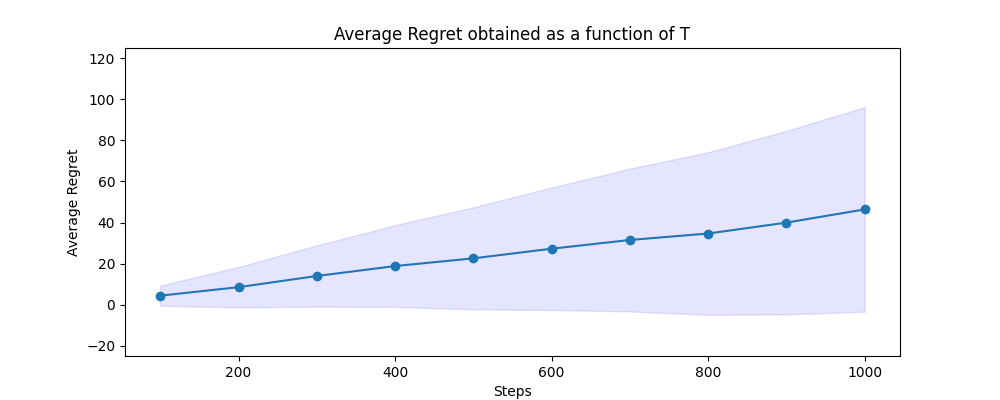

In [59]:
from matplotlib import pyplot as plt
import numpy as np

# Create the data set
T = np.arange(100,1001,100)
avg_regret = [] # For storing means 
std_dev = [] # For storing standard deviation

fig, ax = plt.subplots(figsize =(10, 4))

#  Define the confidence interval
for x in T:
    r = followthelead_regret(1000, x, 2)
    avg_regret.append(np.mean(r))
    std_dev.append(np.std(r))

avg_regret = np.array(avg_regret) 
std_dev = np.array(std_dev) 

# Plot the average function
plt.plot(T, avg_regret, marker = 'o')
plt.ylim(-25, 125)

# Plot the confidence interval
plt.fill_between(T, (avg_regret-std_dev), (avg_regret+std_dev), color='blue', alpha=0.1)

plt.xlabel("Steps")
plt.ylabel("Average Regret")
plt.title("Average Regret obtained as a function of T")

plt.show()

The regret plot is "almost" linear. This is because, as we saw, the action can get stuck in a sub-optimal bandit. So, the regret in that case increases linearly. When we average the regret over a lot of experiments, we see a linear progress as expected.  

Greedy strategy is not a good algorithm because the scope of exploration is almost zero. As we saw above, it could not find the optimal action in a lot of experiments.

***
**Name: Priya Gole**  <br />
**Roll No: 200727** 